# TMDB Rating Prediction Based on Several Factors (Emanuel Azcona)

Is it possible to predict a movie's critic success before it is even released? Are there key/certain cast members (actors/actresses) or essential crew (directors, producers, etc.) that contribute to the critical success of a movie? In this project we investigate and create a an appropiate regression model for predicting a movie's IMDB critic rating based on different attributes like: cast, crew, and more.

In this project, critic rating is given to us in the form of a non-integer score between $0$ and $10$.

## Dataset (TMDB)

The dataset was obtained from Kaggle under: https://www.kaggle.com/tmdb/tmdb-movie-metadata. Per a DMCA takedown request from IMDB, the original IMDB dataset was removed. In order to minimize the impact, Kaggle replaced the dataset with the TMDB dataset, which consists of a similar set of films and data fields in accordance with their terms of use (https://www.themoviedb.org/documentation/api/terms-of-use).

The dataset itself contains two .$\texttt{CSV}$ files:
- $\texttt{tmdb}\text{_}\texttt{5000}\text{_}\texttt{credits.csv}$
- $\texttt{tmdb}\text{_}\texttt{5000}\text{_}\texttt{movies.csv}$

where the "credits" file contains crediting information about the 5000 movies in the datset (title, cast, crew) and the "movies" file contains the following information about each movie:
- budget
- voter rating
- voter count (number of people who voted)
- revenue
- genre(s)
- homepage
- keywords
- original language
- original title
- and way more.

For the purposes of this experiment, we're only going to focus on using the entire "credits" file and the budget/revenue columns of the "movies" file.

### Loading Credits & Movies Files

For data manipulation throughout this experiment, we're going to rely on the Pandas library (available through $\texttt{pip}$ or $\texttt{conda}$).

In [1]:
import pandas as pd # typical naming convention for abbreviating [pandas]
import numpy as np  # using the original NumPy library, not the autograd one (since I'm using Keras)

import ast          # I only use this library to convert strings into their literal Python interpretations

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold    # Sci-kit learn functions for dividing data into testing/training sets using indices

import keras
from keras.models import Sequential          # Very simple sequential layer model making in Keras
from keras.layers import Dense               # Simple fully-connected feed-forward layers in Keras
from keras.layers import Input, add
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [2]:
# load in dataset using pandas
creditsDF = pd.read_csv('tmdb_5000_credits.csv')
moviesDF = pd.read_csv('tmdb_5000_movies.csv')

# sanity check (compare number of samples in each .CSV file)
print('There are ' + str( creditsDF.shape[0] ) + ' movies in the "credits" file.')
print('There are ' + str( moviesDF.shape[0] ) + ' movies in the "movies" file.')

There are 4803 movies in the "credits" file.
There are 4803 movies in the "movies" file.


In [3]:
# I wrote this as a sanity-check to see if every row in each .CSV file corresponds
# to the respective row in the other.
mistakeInData = False
for i in range( creditsDF.shape[0] ):
    if creditsDF['movie_id'][i] != moviesDF['id'][i]:
        mistakeInData = True
if mistakeInData:
    print('\nSomething is up dude. Double-check the data.')
else:
    print('\nDataset is legitimate. Proceed.')
    
# Overview of the first few samples for the movies dataframe
moviesDF.head()


Dataset is legitimate. Proceed.


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [4]:
# Overview of the first few samples for the credits dataframe
creditsDF.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


### Cleaning and Manipulating Data to Create Clean Dictionaries of Movie Information

It's a little annoying to be manipulating two seperate dataframes related to one set of data. For that reason, a single dictionary is created to avoid confusion across datasets. The dictionary data structure was chosen because of its constant, $O(1)$, indexing runtime (I read some forums and documentation warning that Pandas indexing may not run, $O(1)$).

In the process of creating the dictionary, we must be careful to only extract and store information that is relevant and/or may be helpful to determining critic rating. One example of information that may not be helpful that is not included is the homepage to a particular movie.

Throughout the function below, I detail which features I decide to store during each iteration while parsing through the movie dataset.

I also made the decision to remove any movie in the dataset that has less voter counts than the overall median voter count. Why did I decide upon this median metric? I can not give a reasonable answer to that other than, it seemed reasonable. The motivation behind this is credited to some of the movies having unreasonably high ($10$) or low ($0$) ratings with only $1$ or $0$ voters.

In [5]:
def createMovieDictionary(creditsDF, moviesDF):
    
    # initialize dictionary of movies
    movies = {}
    
    # initiailize corresponding set of keys for the movies dictionary
    # I use a set to make sure that no movie has duplicate keys
    keys = set()
    
    # go through every movie in the dataset O(N)
    for i in range(moviesDF.shape[0]):
        
        budget = moviesDF['budget'][i]          # temporarily store the budget for the current movie
        allVoteCounts = moviesDF['vote_count']  # temporarily store vote count for current movie
        medVoteCount = np.median(allVoteCounts) # determine median of the vote counts
        
        # check to see if we're dealing with a non-zero budget movie
        if budget > 0:
            
            # only continue if the current number of votes is bigger than the median
            if allVoteCounts[i] >= medVoteCount:
                
                cast = ast.literal_eval( creditsDF['cast'][i] ) # temporarily extract cast and create a list
                cast = set( [member['name'] for member in cast if member['order'] <= 2] )

                crew = ast.literal_eval( creditsDF['crew'][i] ) # repeat the cast process for the crew members as well
                crew = set( [member['name'] for member in crew if member['job'] == 'Director' or member['job'] == 'Producer'] )
                
                genres = ast.literal_eval( moviesDF['genres'][i] ) # repeat for genres
                genres = set( [g['name'] for g in genres] )
                
                production_companies = ast.literal_eval( moviesDF['production_companies'][i] ) # repeat for production companies
                production_companies = set( [p['name'] for p in production_companies] )
                
                
                # temporarily save movie ID of the movie from id column of current film
                movID = moviesDF['id'][i]

                # temporarily save title of current movie
                title = moviesDF['title'][i]
                
                # temporarily save the rating of the current movie
                rating = moviesDF['vote_average'][i]
                
                # append the set of keys with the current movie's ID
                keys.update({movID})
                
                movies[movID] = {'title': title}              # first entry of the current dictionary is the title
                movies[movID]['cast'] = cast                  # assign set of cast members
                movies[movID]['crew'] = crew                  # assign set of crew members
                movies[movID]['budget'] = budget              # assign budget
                movies[movID]['rate'] = rating                # assign rating
                movies[movID]['genres'] = genres              # assign genres
                movies[movID]['prod'] = production_companies  # assign production companies

    return movies, keys

In [6]:
movies, keys = createMovieDictionary(creditsDF,moviesDF)

# I'm paranoid, so I'm just deleting these dataframes now to free up some space
del moviesDF, creditsDF

# Another sanity check
print("The movie dictionary has: " + str(len(movies)) + " entries." )

The movie dictionary has: 2302 entries.


### Determine Distinct Items Pertaining to Features That Are Sets/Lists

Next, a function was created to create individual sets of the distinct cast, crew, genres, and production companies in the movies we extracted. We can utilize the Python $\texttt{set}(\cdot)$ method that creates a distinct set data structure for eliminating repeat cast or crew members.

In [7]:
def distinctThings(movies, key):
    
    # only return a set if the key entered is cast, crew, genres, or production companies
    if key in ['cast', 'crew', 'genres', 'prod']:
        
        distinct = set() # create distinction set
        
        for m in movies:                # iterate through all the movies in the dictionary
            for member in movies[m][key]: # iterate through the list pertaining to the key
                distinct.update({member})
        return distinct
    else:
        return None

distinctCast = distinctThings(movies, 'cast')
distinctCrew = distinctThings(movies, 'crew')
distinctGenres = distinctThings(movies, 'genres')
distinctProd = distinctThings(movies, 'prod')

# Create Rating Regression Model Based Only on Budget

### Simple 1-D Feature & 1-D Predictor Regression Model (Rating Based on Budget)

Time to play around with the data! To start things off, we can first create a simple regression model using a very minimal deep-feedforward network in Keras.

Before doing anything, two functions were created, createFeatures() and createPredictors(), that let us create feature/predictor matrices using NumPy. Keras by default takes in NumPy arrays as data inputs.

In [8]:
N_samples = len(movies)

def createFeatures(feature):
    
    abort = False
    # if we're only using the budget, we'll have a single column for X
    if feature is 'budget':
        N_features = 1
    
    # otherwise N_features is # of distinct possible cast, crew, etc.
    elif feature is 'cast':              
        N_features = len(distinctCast)
    elif feature is 'crew':
        N_features = len(distinctCrew)
    elif feature is 'genres':
        N_features = len(distinctGenres)
    elif feature is 'prod':
        N_features = len(distinctProd)
    else:
        abort = True
    
    # if the number of features is still 0, then obviously we didn't input 1 of the above ^
    if abort:
        return None, None
    else:
        # initialize  data array to array of zeros
        # in the case of the feature being anything else besides budget, we will have a mostly sparse array
        X = np.zeros( (N_samples, N_features) )

        # iterate over keys set we created earlier (so we can iterate through the movies)
        # "i" in this case will be the corresponding row to a movie (starting at 0)
        for i, ID in enumerate(keys):
            currentMovie = movies[ID]
            
            # budget results in a 1-dimensional feature fector
            if feature is 'budget':
                X[i, 0] = currentMovie[feature]
            
            # all other features result in NxM feature matrices (very sparse for all)
            else:
                if feature is 'cast':
                    for j, member in enumerate(distinctCast):
                        if member in currentMovie[feature]:
                            X[i,j] = 1
                
                elif feature is 'crew':
                    for j, member in enumerate(distinctCrew):
                        if member in currentMovie[feature]:
                            X[i,j] = 1
                
                elif feature is 'genres':
                    for j, member in enumerate(distinctGenres):
                        if member in currentMovie[feature]:
                            X[i,j] = 1
                
                else:
                    for j, member in enumerate(distinctProd):
                        if member in currentMovie[feature]:
                            X[i,j] = 1

        return X

# short function for creating 1-dimensional predictor vector 
def createPredictors():
    y = np.zeros((N_samples,1))
    for i, ID in enumerate(keys):
        currentMovie = movies[ID]
        
        y[i,0] = currentMovie['rate']
    return y

In [9]:
X = createFeatures('budget')
y = createPredictors()

# sanity check
print(X.shape, y.shape)

((2302, 1), (2302, 1))


### Normalize Input Data (Optimization Trick to Reduce # of Epochs Required for Training)

Here, we utilize an optimization trick (normalizing the input data) that helps in reducing the number of epochs required for training. There are many methods for normalizing a vector. A common one being:

\begin{equation}
    \vec{x}_{norm} = \frac{\vec{x} - \mu_x}{\sigma_x}
\end{equation}

In this project, we use the Scikit-learn library which provides a normalization function that uses the $\mathcal{l}_2$ norm for normalization.

\begin{equation}
    \vec{x}_{norm} = \frac{\vec{x}}{\|\vec{x}\|_2}
\end{equation}

In [10]:
Xnorm = normalize(X, axis = 0, norm = 'l2')

### Using Keras (Tensorflow Backend)

Keras is a high-level neural network API, for Python, for use on top of Tensorflow, CNTK, or Theano. Since Theano updates will soon stop, and Tensorflow (although slow for the time being) is Google-backed and owned I used Keras with a Tensorflow backend.

Rather than viewing the losses throughout training, a Keras callback was defined below to store loss history.

In [11]:
# self-defined keras callback for saving a history of losses per epoch during training
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append([logs.get('loss'), logs.get('val_loss')])

In [12]:
seed = 7  # random number generator seed value (all cases will use 7 from here on out)
folds = 4 # 3/4 training - 1/4 testing split

# create instance of weight intializer for keras layers using seed
initialWeights = keras.initializers.RandomNormal(mean=0.0, stddev=0.07, seed=seed)

# create folding object using same seed and fold #
kfold = KFold(n_splits=folds, shuffle=True, random_state=seed)

num_epochs = 20

# K*Epoch array for storing training/validation loss history for each random fold
cvScoresHistory = []

for k, (train, test) in enumerate(kfold.split(Xnorm, y)):
    model = Sequential() # feed-forward network instantiation
    
    # 1st fully-connected dense layer (input data encounters this)
    model.add(Dense(units=128, kernel_initializer= initialWeights, activation = 'relu', input_dim=X.shape[1]))
    
    model.add(Dense(units=64, kernel_initializer= initialWeights, activation = 'relu')) # 2nd fully-connected layer
    model.add(Dense(units=32, kernel_initializer= initialWeights, activation = 'relu')) # 3rd .. .. .. .. ..
    
    # Final fully-connected layer ("y-hat")
    model.add(Dense(units=1, kernel_initializer= initialWeights, activation = 'relu'))
    
    # loss function and optimization technique specification for model
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    
    # loss-history callback instantiation
    history = LossHistory()
    
    # begin training
    model.fit(Xnorm[train], 
              y[train], 
              validation_data = (Xnorm[test],y[test]), 
              epochs=num_epochs, 
              batch_size=64, 
              verbose=1, 
              callbacks = [history]
             )
    
    # append current training and validation loss history for current fold
    cvScoresHistory.append(history.losses)

Train on 1726 samples, validate on 576 samples
Epoch 1/20
1726/1726 [==============================] - 0s - loss: 6.4098 - val_loss: 6.3242
Epoch 2/20
1726/1726 [==============================] - 0s - loss: 6.0166 - val_loss: 5.4229
Epoch 3/20
1726/1726 [==============================] - 0s - loss: 3.8255 - val_loss: 1.1596
Epoch 4/20
1726/1726 [==============================] - 0s - loss: 0.8215 - val_loss: 0.7329
Epoch 5/20
1726/1726 [==============================] - 0s - loss: 0.6785 - val_loss: 0.6476
Epoch 6/20
1726/1726 [==============================] - 0s - loss: 0.6660 - val_loss: 0.6459
Epoch 7/20
1726/1726 [==============================] - 0s - loss: 0.6610 - val_loss: 0.6449
Epoch 8/20
1726/1726 [==============================] - 0s - loss: 0.6580 - val_loss: 0.6418
Epoch 9/20
1726/1726 [==============================] - 0s - loss: 0.6559 - val_loss: 0.6454
Epoch 10/20
1726/1726 [==============================] - 0s - loss: 0.6585 - val_loss: 0.6421
Epoch 11/20
1726/1726 

### Plotting Training and Validation Loss History

To save time for future parts, I created a function that plots the training and validation loss history throughout training for our models. The average training and validation loss were also plotted.

In [13]:
def plotCrossValScores(scores, folds, epochs):
    
    trainingLossHistory = scores[:].T[0].T
    validationLossHistory = scores[:].T[1].T

    meanTrainingLossHistory = np.mean(trainingLossHistory, axis = 0)
    meanValidationLossHistory = np.mean(validationLossHistory, axis = 0)
    
    gs = gridspec.GridSpec(folds+1, 2) # create two seperate columns for the training / validation loss
    f = plt.figure(figsize= (40, 30))  # construct figure with set size
    
    # loop through the number of folds
    for i in range(folds):
        
        # training loss column
        curr = f.add_subplot(gs[i,0])
        curr.plot(trainingLossHistory[i], 'o', markersize = 13)
        curr.set_ylabel('Fold-' + str(i+1), fontsize = 27)
        curr.tick_params(labelsize = 18)
        curr.grid()
        if i is 0:
            curr.set_title('Training Loss', fontsize = 35)
        elif i is folds-1:
            curr.set_xlabel('Epochs', fontsize = 27)
        
        # validation loss column
        curr = f.add_subplot(gs[i,1])
        curr.plot(validationLossHistory[i],'o', markersize = 13)
        curr.set_ylabel('Fold-' + str(i+1), fontsize = 27)
        curr.tick_params(labelsize = 18)
        curr.grid()
        if i is 0:
            curr.set_title('Validation Loss', fontsize = 35)
        elif i is folds-1:
            curr.set_xlabel('Epochs', fontsize = 27)
    
    # mean training/validation loss plot (spans both columns)
    curr = f.add_subplot(gs[-1,:])
    curr.set_title('Mean Training/Validation Loss', fontsize = 30)
    curr.plot(meanTrainingLossHistory, 'o', label = 'Avg. Training Loss', markersize = 13)
    curr.plot(meanValidationLossHistory, 'o', label = 'Avg. Validation Loss', markersize = 13)
    curr.tick_params(labelsize = 18)
    curr.legend(fontsize = 27)
    curr.set_xlabel('Epoch', fontsize = 27)
    curr.set_ylabel('Mean Absolute Error Cost', fontsize = 27)
    curr.grid(True)
    plt.show()
    
    return meanTrainingLossHistory, meanValidationLossHistory

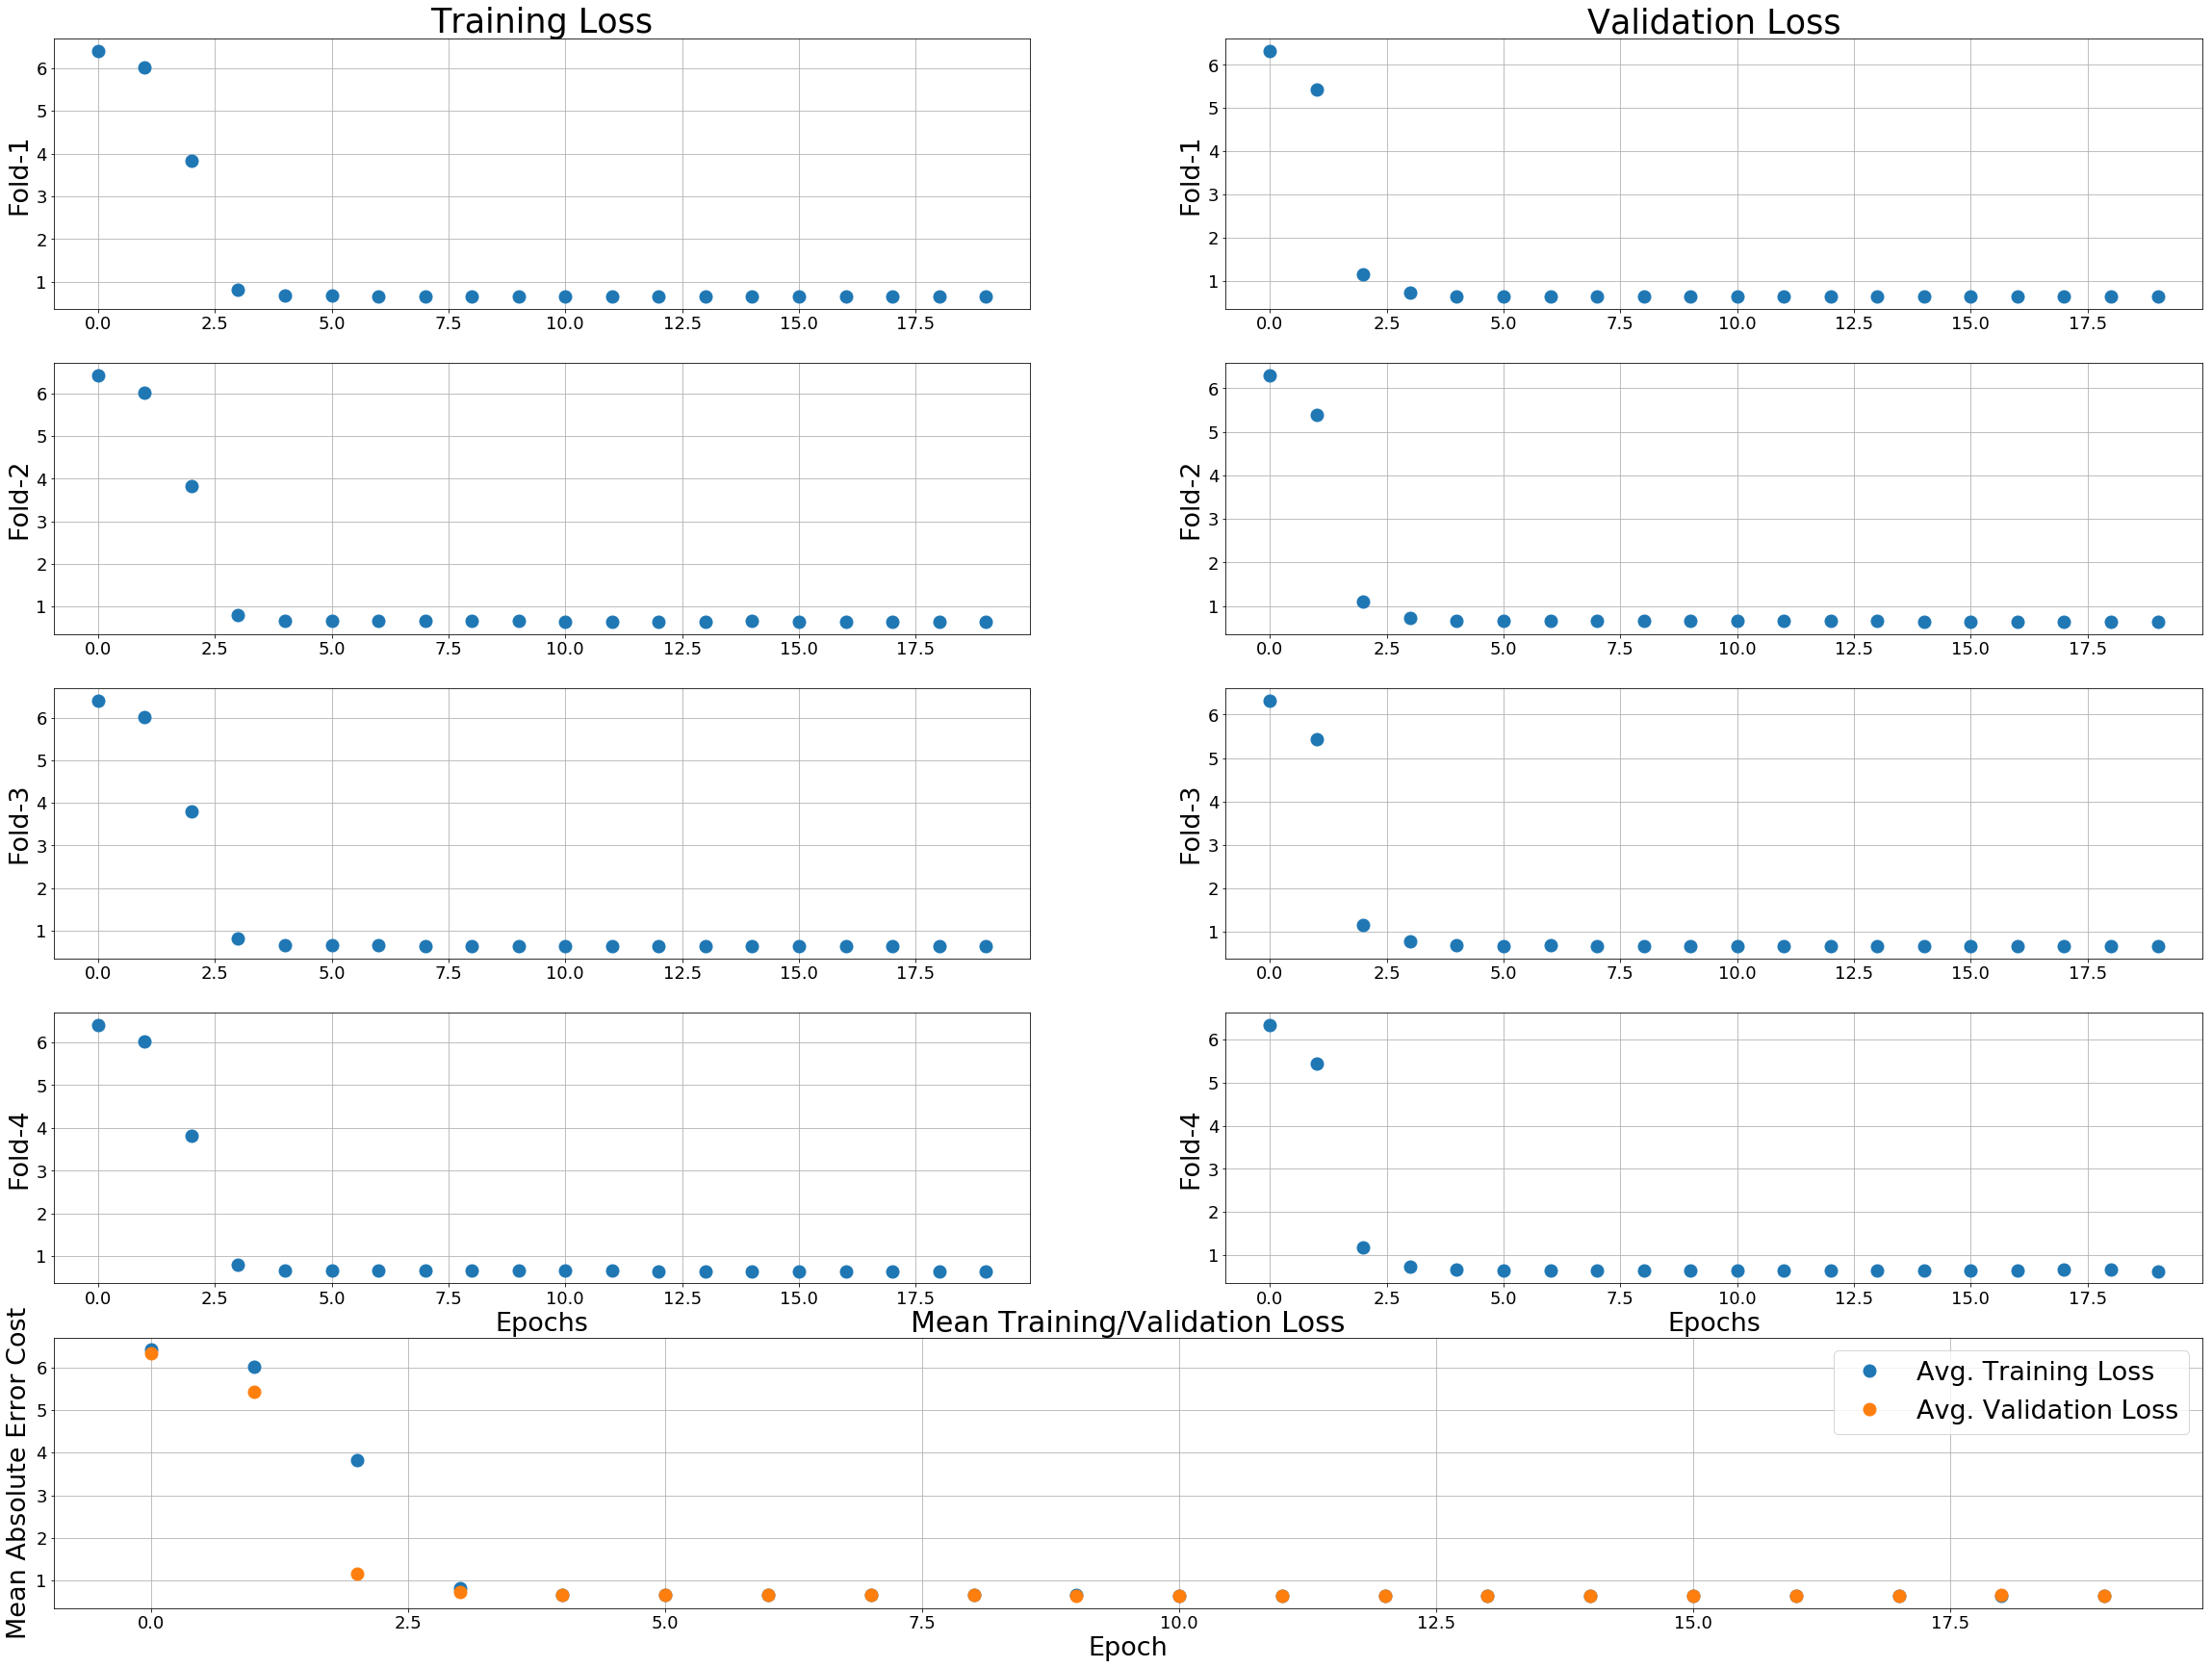

In [14]:
cvScoresHistory = np.asarray(cvScoresHistory)
meanTrainingLossHistory, meanValidationLossHistory = plotCrossValScores(cvScoresHistory, folds, num_epochs)

### This Is Good News!

This is great! It seems that the validation loss and training loss are at a pass and stay constant after about 10 epochs of stochastic gradient descent. Since we decided to use the mean absolute error cost function, it is easy to see that after 10 epochs of training we our average error across when using budgets to predict ratings is off by $\approx \pm 0.6$. This error rate is on a scale with ratings that range between 0 and 10.

One very useful metric to determine is which set of weights for our network were the "most useful." One way to determine this is to sort the validation and training losses  in lexicographical order.

Luckily, the NumPy library provides a function, lexsort(), that does lexicographical sorting and returns the indices of the order for the elements. In other words, we sort our loss data, first by order from smallest to largest validation loss, and then from smallest to largest training loss.

In [15]:
ind = np.lexsort( (meanTrainingLossHistory, meanValidationLossHistory) )
print('"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss\n')
print(ind)

print("\nTherefore, Epoch:" + str(ind[0]) + " would be a good place to stop training this model.")

"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss

[19 15 16 14 11 13 10 12  9 17 18  7  8  6  5  4  3  2  1  0]

Therefore, Epoch:19 would be a good place to stop training this model.


# REPEAT NOW: Create Rating Regression Model Based Only Top 3 Paid Cast Members

In [16]:
X = createFeatures('cast')
Xnorm = normalize(X, axis = 0, norm = 'l2')

In [17]:
num_epochs = 50

# K*Epoch array for storing training/validation loss history for each random fold
cvScoresHistory = []

for k, (train, test) in enumerate(kfold.split(Xnorm, y)):
    model = Sequential() # feed-forward network instantiation
    
    # 1st fully-connected dense layer (input data encounters this)
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu', input_dim=X.shape[1]))
    
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu')) # 2nd fully-connected layer
    model.add(Dense(units=128, kernel_initializer= initialWeights, activation = 'relu')) # 3rd .. .. .. .. ..
    
    # Final fully-connected layer ("y-hat")
    model.add(Dense(units=1, kernel_initializer= initialWeights, activation = 'relu'))
    
    # loss function and optimization technique specification for model
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    
    # loss-history callback instantiation
    history = LossHistory()
    
    # begin training
    model.fit(Xnorm[train], 
              y[train], 
              validation_data = (Xnorm[test],y[test]), 
              epochs=num_epochs, 
              batch_size=64, 
              verbose=1, 
              callbacks = [history]
             )
    
    # append current training and validation loss history for current fold
    cvScoresHistory.append(history.losses)

Train on 1726 samples, validate on 576 samples
Epoch 1/50
1726/1726 [==============================] - 0s - loss: 4.3715 - val_loss: 2.2000
Epoch 2/50
1726/1726 [==============================] - 0s - loss: 1.4747 - val_loss: 1.0248
Epoch 3/50
1726/1726 [==============================] - 0s - loss: 0.7967 - val_loss: 0.7951
Epoch 4/50
1726/1726 [==============================] - 0s - loss: 0.5018 - val_loss: 0.7514
Epoch 5/50
1726/1726 [==============================] - 0s - loss: 0.3803 - val_loss: 0.7400
Epoch 6/50
1726/1726 [==============================] - 0s - loss: 0.3192 - val_loss: 0.7317
Epoch 7/50
1726/1726 [==============================] - 0s - loss: 0.2932 - val_loss: 0.7458
Epoch 8/50
1726/1726 [==============================] - 0s - loss: 0.2745 - val_loss: 0.7364
Epoch 9/50
1726/1726 [==============================] - 0s - loss: 0.2624 - val_loss: 0.7217
Epoch 10/50
1726/1726 [==============================] - 0s - loss: 0.2516 - val_loss: 0.7395
Epoch 11/50
1726/1726 

1726/1726 [==============================] - 0s - loss: 0.1733 - val_loss: 0.6775
Epoch 38/50
1726/1726 [==============================] - 0s - loss: 0.1743 - val_loss: 0.6698
Epoch 39/50
1726/1726 [==============================] - 0s - loss: 0.1800 - val_loss: 0.6732
Epoch 40/50
1726/1726 [==============================] - 0s - loss: 0.1774 - val_loss: 0.6666
Epoch 41/50
1726/1726 [==============================] - 0s - loss: 0.1745 - val_loss: 0.6815
Epoch 42/50
1726/1726 [==============================] - 0s - loss: 0.1635 - val_loss: 0.6680
Epoch 43/50
1726/1726 [==============================] - 0s - loss: 0.1573 - val_loss: 0.6647
Epoch 44/50
1726/1726 [==============================] - 0s - loss: 0.1654 - val_loss: 0.6667
Epoch 45/50
1726/1726 [==============================] - 0s - loss: 0.1773 - val_loss: 0.6756
Epoch 46/50
1726/1726 [==============================] - 0s - loss: 0.1783 - val_loss: 0.6685
Epoch 47/50
1726/1726 [==============================] - 0s - loss: 0.17

1727/1727 [==============================] - 0s - loss: 0.2084 - val_loss: 0.7347
Epoch 24/50
1727/1727 [==============================] - 0s - loss: 0.2096 - val_loss: 0.7353
Epoch 25/50
1727/1727 [==============================] - 0s - loss: 0.2178 - val_loss: 0.7419
Epoch 26/50
1727/1727 [==============================] - 0s - loss: 0.1928 - val_loss: 0.7425
Epoch 27/50
1727/1727 [==============================] - 0s - loss: 0.1967 - val_loss: 0.7557
Epoch 28/50
1727/1727 [==============================] - 0s - loss: 0.2152 - val_loss: 0.7486
Epoch 29/50
1727/1727 [==============================] - 0s - loss: 0.2064 - val_loss: 0.7337
Epoch 30/50
1727/1727 [==============================] - 0s - loss: 0.1953 - val_loss: 0.7447
Epoch 31/50
1727/1727 [==============================] - 0s - loss: 0.1830 - val_loss: 0.7413
Epoch 32/50
1727/1727 [==============================] - 0s - loss: 0.1691 - val_loss: 0.7360
Epoch 33/50
1727/1727 [==============================] - 0s - loss: 0.17

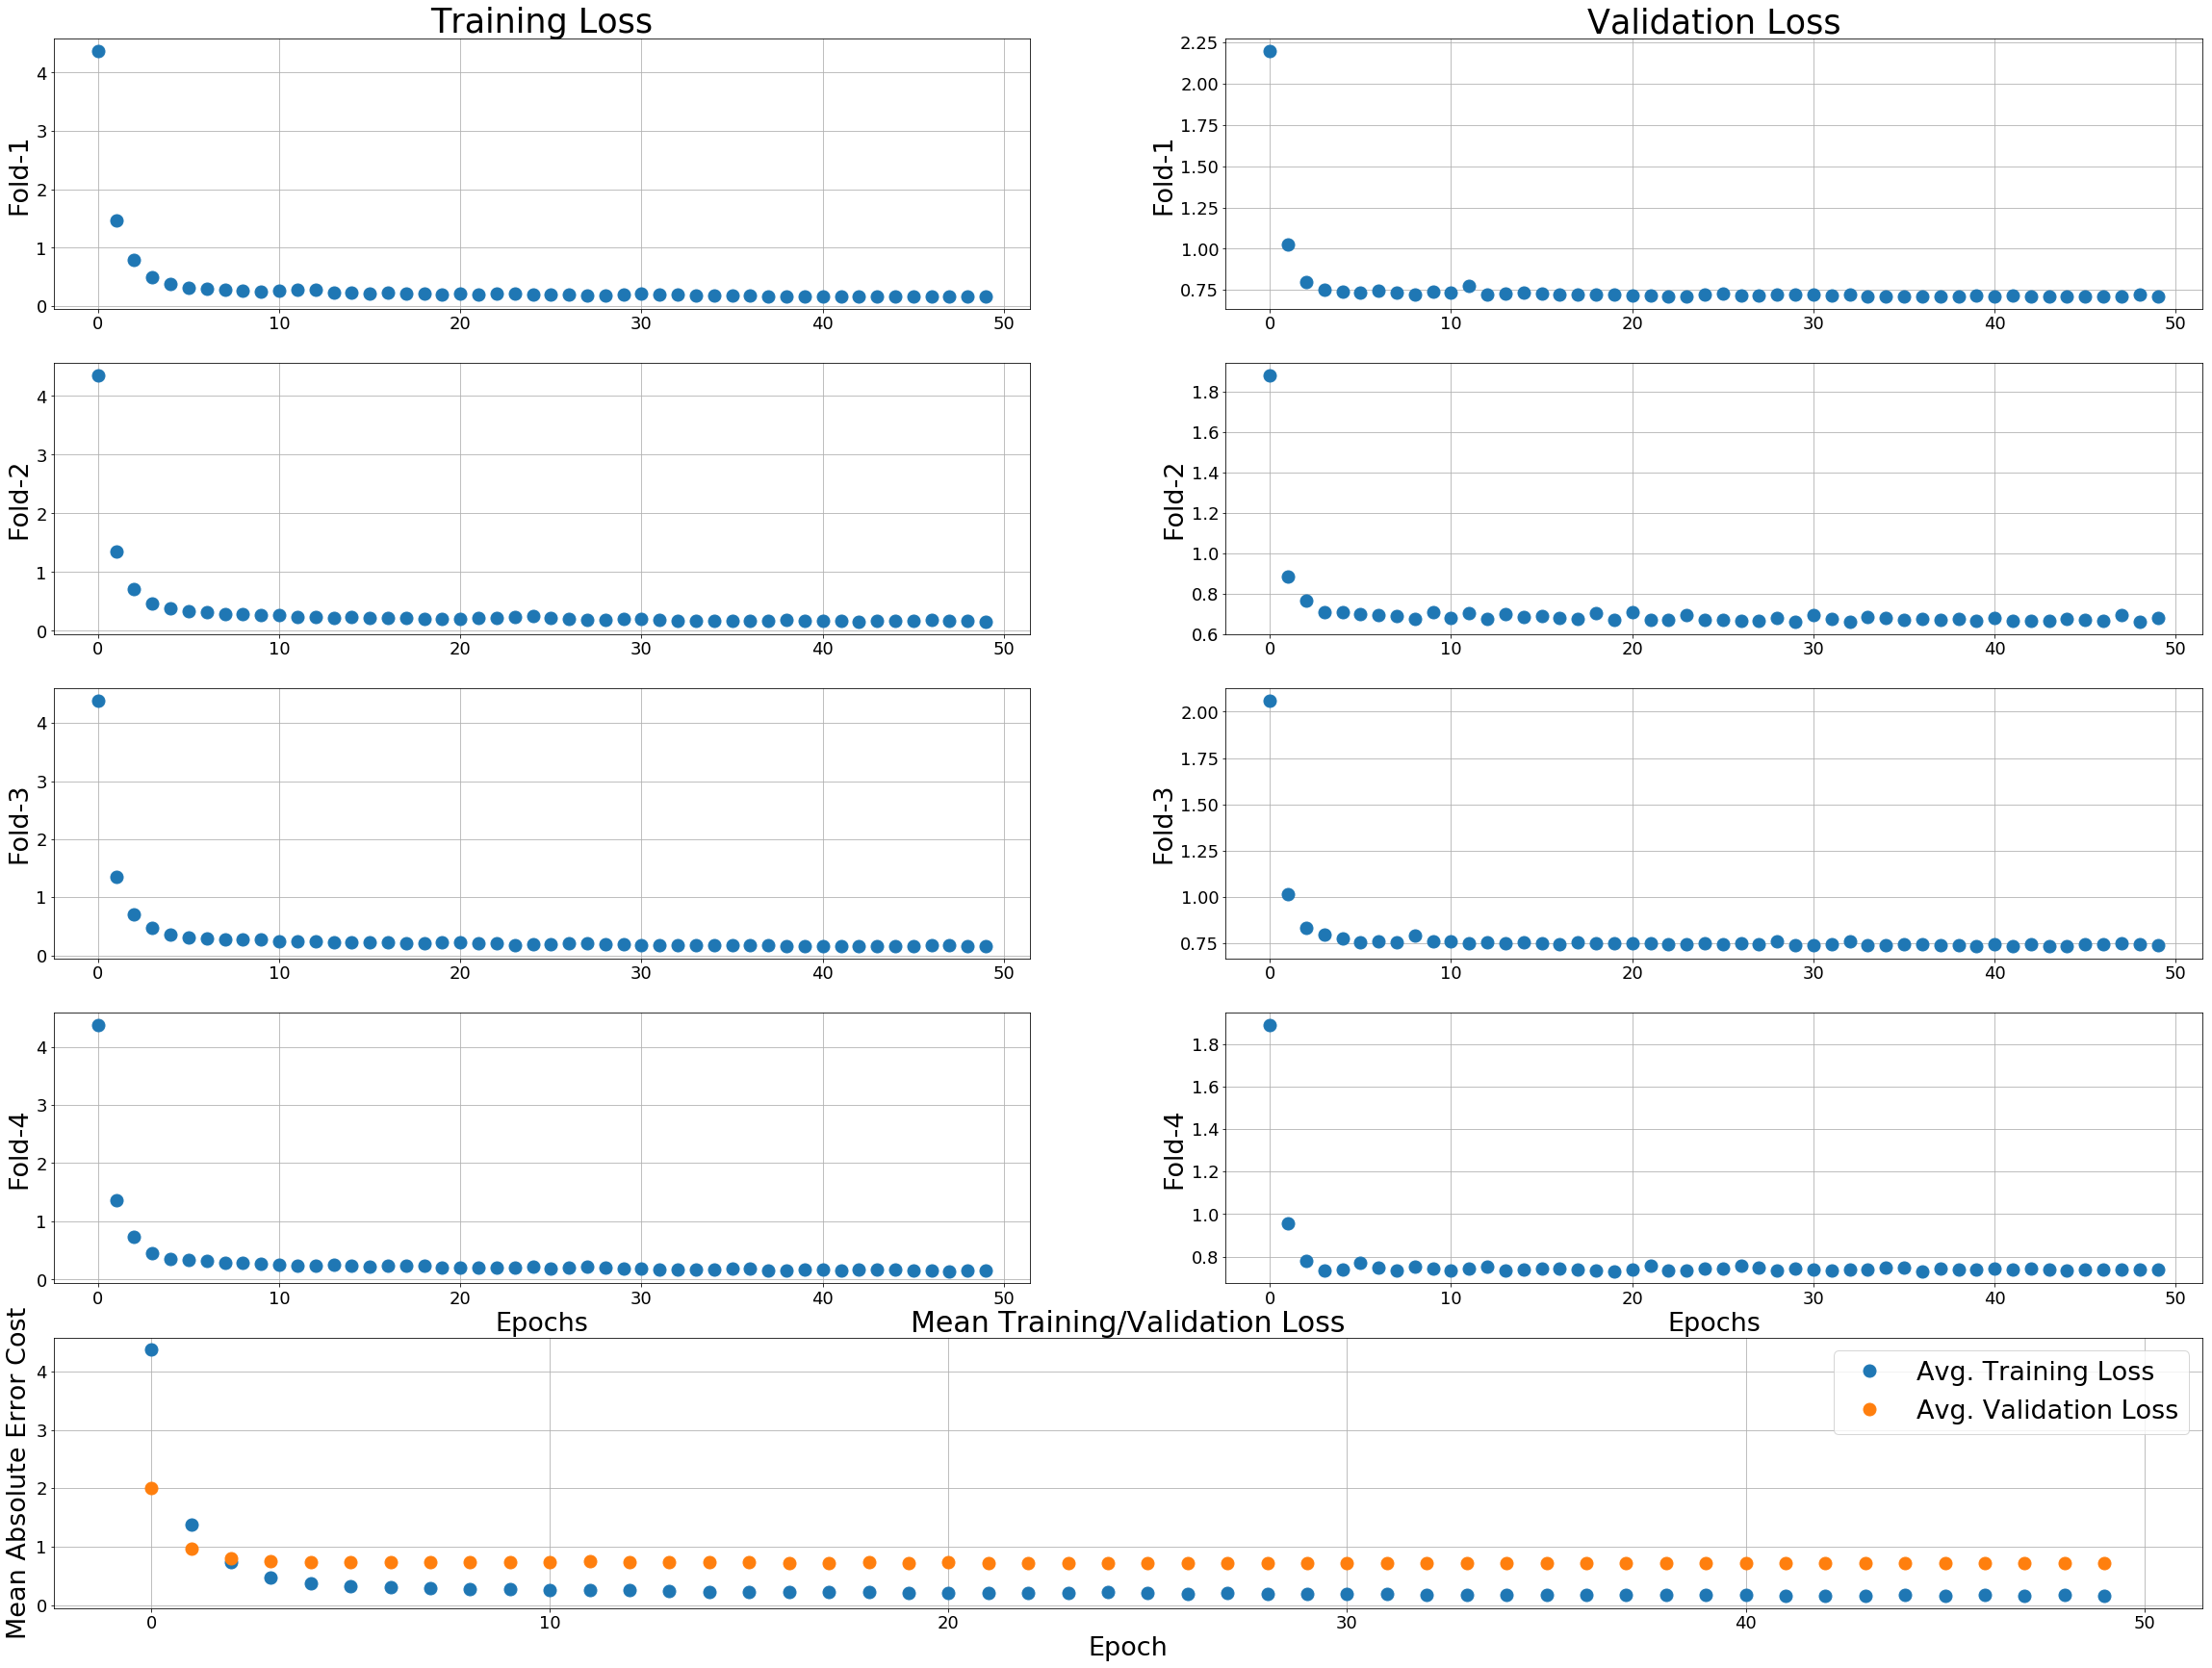

In [18]:
cvScoresHistory = np.asarray(cvScoresHistory)
meanTrainingLossHistory, meanValidationLossHistory = plotCrossValScores(cvScoresHistory, folds, num_epochs)

In [19]:
ind = np.lexsort( (meanTrainingLossHistory, meanValidationLossHistory) )
print('"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss\n')
print(ind)

print("\nTherefore, Epoch:" + str(ind[0]) + " would be a good place to stop training this model.")

"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss

[43 39 44 41 45 22 46 36 42 37 38 49 48 31 29 35 19 33 27 40 34 23 25 24 32
 17 26 16 30 28 21 47 12 18 15 10 13  7 20 14  8  6  9  5  4 11  3  2  1  0]

Therefore, Epoch:43 would be a good place to stop training this model.


### But Does the Model Really Work?

To test this question, artificial data was created in which we cast only 1 of our cast members per movie. In other words, we create 1 movie for every actor/actress in our "distinctCast" array, and in each movie we only cast the corresponding cast member.

Using this array of data and a trained model, we can apply these artifical movies to our regression model and predict the ratings for these fake movies. From these fake movies we can sort their ratings from greatest to least and view who the "top choices" would be to get the highest voter rating average.

In [20]:
Xset = []
for i in range(0, len(distinctCast)):
    Xcurr = np.zeros((1,X.shape[1]))
    Xcurr[0,i] = 1
    Xset.append(Xcurr)
    

predictions = []
for castMember in Xset:
    predictions.append(float(model.predict(castMember)))

idx = np.argsort(predictions)

In [21]:
dList = list(distinctCast)

print('The best choices to make if you were to a cast only one "top-3" cast member would be:\n')
for i in idx[-1:-20:-1]:
    print(list(dList)[i])

The best choices to make if you were to a cast only one "top-3" cast member would be:

Brad Pitt
Denzel Washington
Vin Diesel
Leonardo DiCaprio
Tom Hanks
Joe Pesci
Elijah Wood
Robert De Niro
Clint Eastwood
Alec Baldwin
Joaquin Phoenix
Ed Harris
Bruce Willis
Kristen Wiig
Robert Redford
Ralph Fiennes
Robert Downey Jr.
Jared Leto
Marlon Brando


Given the state of the film industry today, the names that this model was able extrapolate are of various actors/actresses who have appeared in a lot of critically and commercially successful films, such as Brad Pitt, Tom Hanks, Leonardo Dicaprio, etc.

# REPEAT NOW: Create Rating Regression Model Based Only On Director & Producer

In [22]:
X = createFeatures('crew')
Xnorm = normalize(X, axis = 0, norm = 'l2')

In [23]:
num_epochs = 80

# K*Epoch array for storing training/validation loss history for each random fold
cvScoresHistory = []

for k, (train, test) in enumerate(kfold.split(Xnorm, y)):
    model = Sequential() # feed-forward network instantiation
    
    # 1st fully-connected dense layer (input data encounters this)
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu', input_dim=X.shape[1]))
    
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu')) # 2nd fully-connected layer
    model.add(Dense(units=128, kernel_initializer= initialWeights, activation = 'relu')) # 3rd .. .. .. .. ..
    
    # Final fully-connected layer ("y-hat")
    model.add(Dense(units=1, kernel_initializer= initialWeights, activation = 'relu'))
    
    # loss function and optimization technique specification for model
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    
    # loss-history callback instantiation
    history = LossHistory()
    
    # begin training
    model.fit(Xnorm[train], 
              y[train], 
              validation_data = (Xnorm[test],y[test]), 
              epochs=num_epochs, 
              batch_size=64, 
              verbose=1, 
              callbacks = [history]
             )
    
    # append current training and validation loss history for current fold
    cvScoresHistory.append(history.losses)

Train on 1726 samples, validate on 576 samples
Epoch 1/80
1726/1726 [==============================] - 0s - loss: 4.3557 - val_loss: 2.2309
Epoch 2/80
1726/1726 [==============================] - 0s - loss: 1.6394 - val_loss: 1.1901
Epoch 3/80
1726/1726 [==============================] - 0s - loss: 0.8891 - val_loss: 0.9349
Epoch 4/80
1726/1726 [==============================] - 0s - loss: 0.5602 - val_loss: 0.8449
Epoch 5/80
1726/1726 [==============================] - 0s - loss: 0.4302 - val_loss: 0.8491
Epoch 6/80
1726/1726 [==============================] - 0s - loss: 0.3759 - val_loss: 0.8169
Epoch 7/80
1726/1726 [==============================] - 0s - loss: 0.3313 - val_loss: 0.7957
Epoch 8/80
1726/1726 [==============================] - 0s - loss: 0.3019 - val_loss: 0.7979
Epoch 9/80
1726/1726 [==============================] - 0s - loss: 0.2899 - val_loss: 0.7849
Epoch 10/80
1726/1726 [==============================] - 0s - loss: 0.2883 - val_loss: 0.7744
Epoch 11/80
1726/1726 

1726/1726 [==============================] - 0s - loss: 0.3291 - val_loss: 0.8215
Epoch 8/80
1726/1726 [==============================] - 0s - loss: 0.3055 - val_loss: 0.8603
Epoch 9/80
1726/1726 [==============================] - 0s - loss: 0.2977 - val_loss: 0.8198
Epoch 10/80
1726/1726 [==============================] - 0s - loss: 0.2894 - val_loss: 0.8133
Epoch 11/80
1726/1726 [==============================] - 0s - loss: 0.2905 - val_loss: 0.8380
Epoch 12/80
1726/1726 [==============================] - 0s - loss: 0.2667 - val_loss: 0.8048
Epoch 13/80
1726/1726 [==============================] - 0s - loss: 0.2501 - val_loss: 0.7924
Epoch 14/80
1726/1726 [==============================] - 0s - loss: 0.2408 - val_loss: 0.7706
Epoch 15/80
1726/1726 [==============================] - 0s - loss: 0.2395 - val_loss: 0.7803
Epoch 16/80
1726/1726 [==============================] - 0s - loss: 0.2297 - val_loss: 0.7660
Epoch 17/80
1726/1726 [==============================] - 0s - loss: 0.2204

1727/1727 [==============================] - 0s - loss: 0.2547 - val_loss: 0.8757
Epoch 14/80
1727/1727 [==============================] - 0s - loss: 0.2434 - val_loss: 0.8317
Epoch 15/80
1727/1727 [==============================] - 0s - loss: 0.2415 - val_loss: 0.8241
Epoch 16/80
1727/1727 [==============================] - 0s - loss: 0.2256 - val_loss: 0.8027
Epoch 17/80
1727/1727 [==============================] - 0s - loss: 0.2377 - val_loss: 0.8153
Epoch 18/80
1727/1727 [==============================] - 0s - loss: 0.2258 - val_loss: 0.8010
Epoch 19/80
1727/1727 [==============================] - 0s - loss: 0.2189 - val_loss: 0.7952
Epoch 20/80
1727/1727 [==============================] - 0s - loss: 0.2064 - val_loss: 0.8029
Epoch 21/80
1727/1727 [==============================] - 0s - loss: 0.2048 - val_loss: 0.7988
Epoch 22/80
1727/1727 [==============================] - 0s - loss: 0.2146 - val_loss: 0.7797
Epoch 23/80
1727/1727 [==============================] - 0s - loss: 0.21

1727/1727 [==============================] - 0s - loss: 0.2258 - val_loss: 0.7357
Epoch 20/80
1727/1727 [==============================] - 0s - loss: 0.2210 - val_loss: 0.7203
Epoch 21/80
1727/1727 [==============================] - 0s - loss: 0.2079 - val_loss: 0.7233
Epoch 22/80
1727/1727 [==============================] - 0s - loss: 0.2102 - val_loss: 0.7209
Epoch 23/80
1727/1727 [==============================] - 0s - loss: 0.2095 - val_loss: 0.7397
Epoch 24/80
1727/1727 [==============================] - 0s - loss: 0.2201 - val_loss: 0.7046
Epoch 25/80
1727/1727 [==============================] - 0s - loss: 0.2089 - val_loss: 0.7012
Epoch 26/80
1727/1727 [==============================] - 0s - loss: 0.2041 - val_loss: 0.7050
Epoch 27/80
1727/1727 [==============================] - 0s - loss: 0.1975 - val_loss: 0.6978
Epoch 28/80
1727/1727 [==============================] - 0s - loss: 0.2041 - val_loss: 0.7625
Epoch 29/80
1727/1727 [==============================] - 0s - loss: 0.21

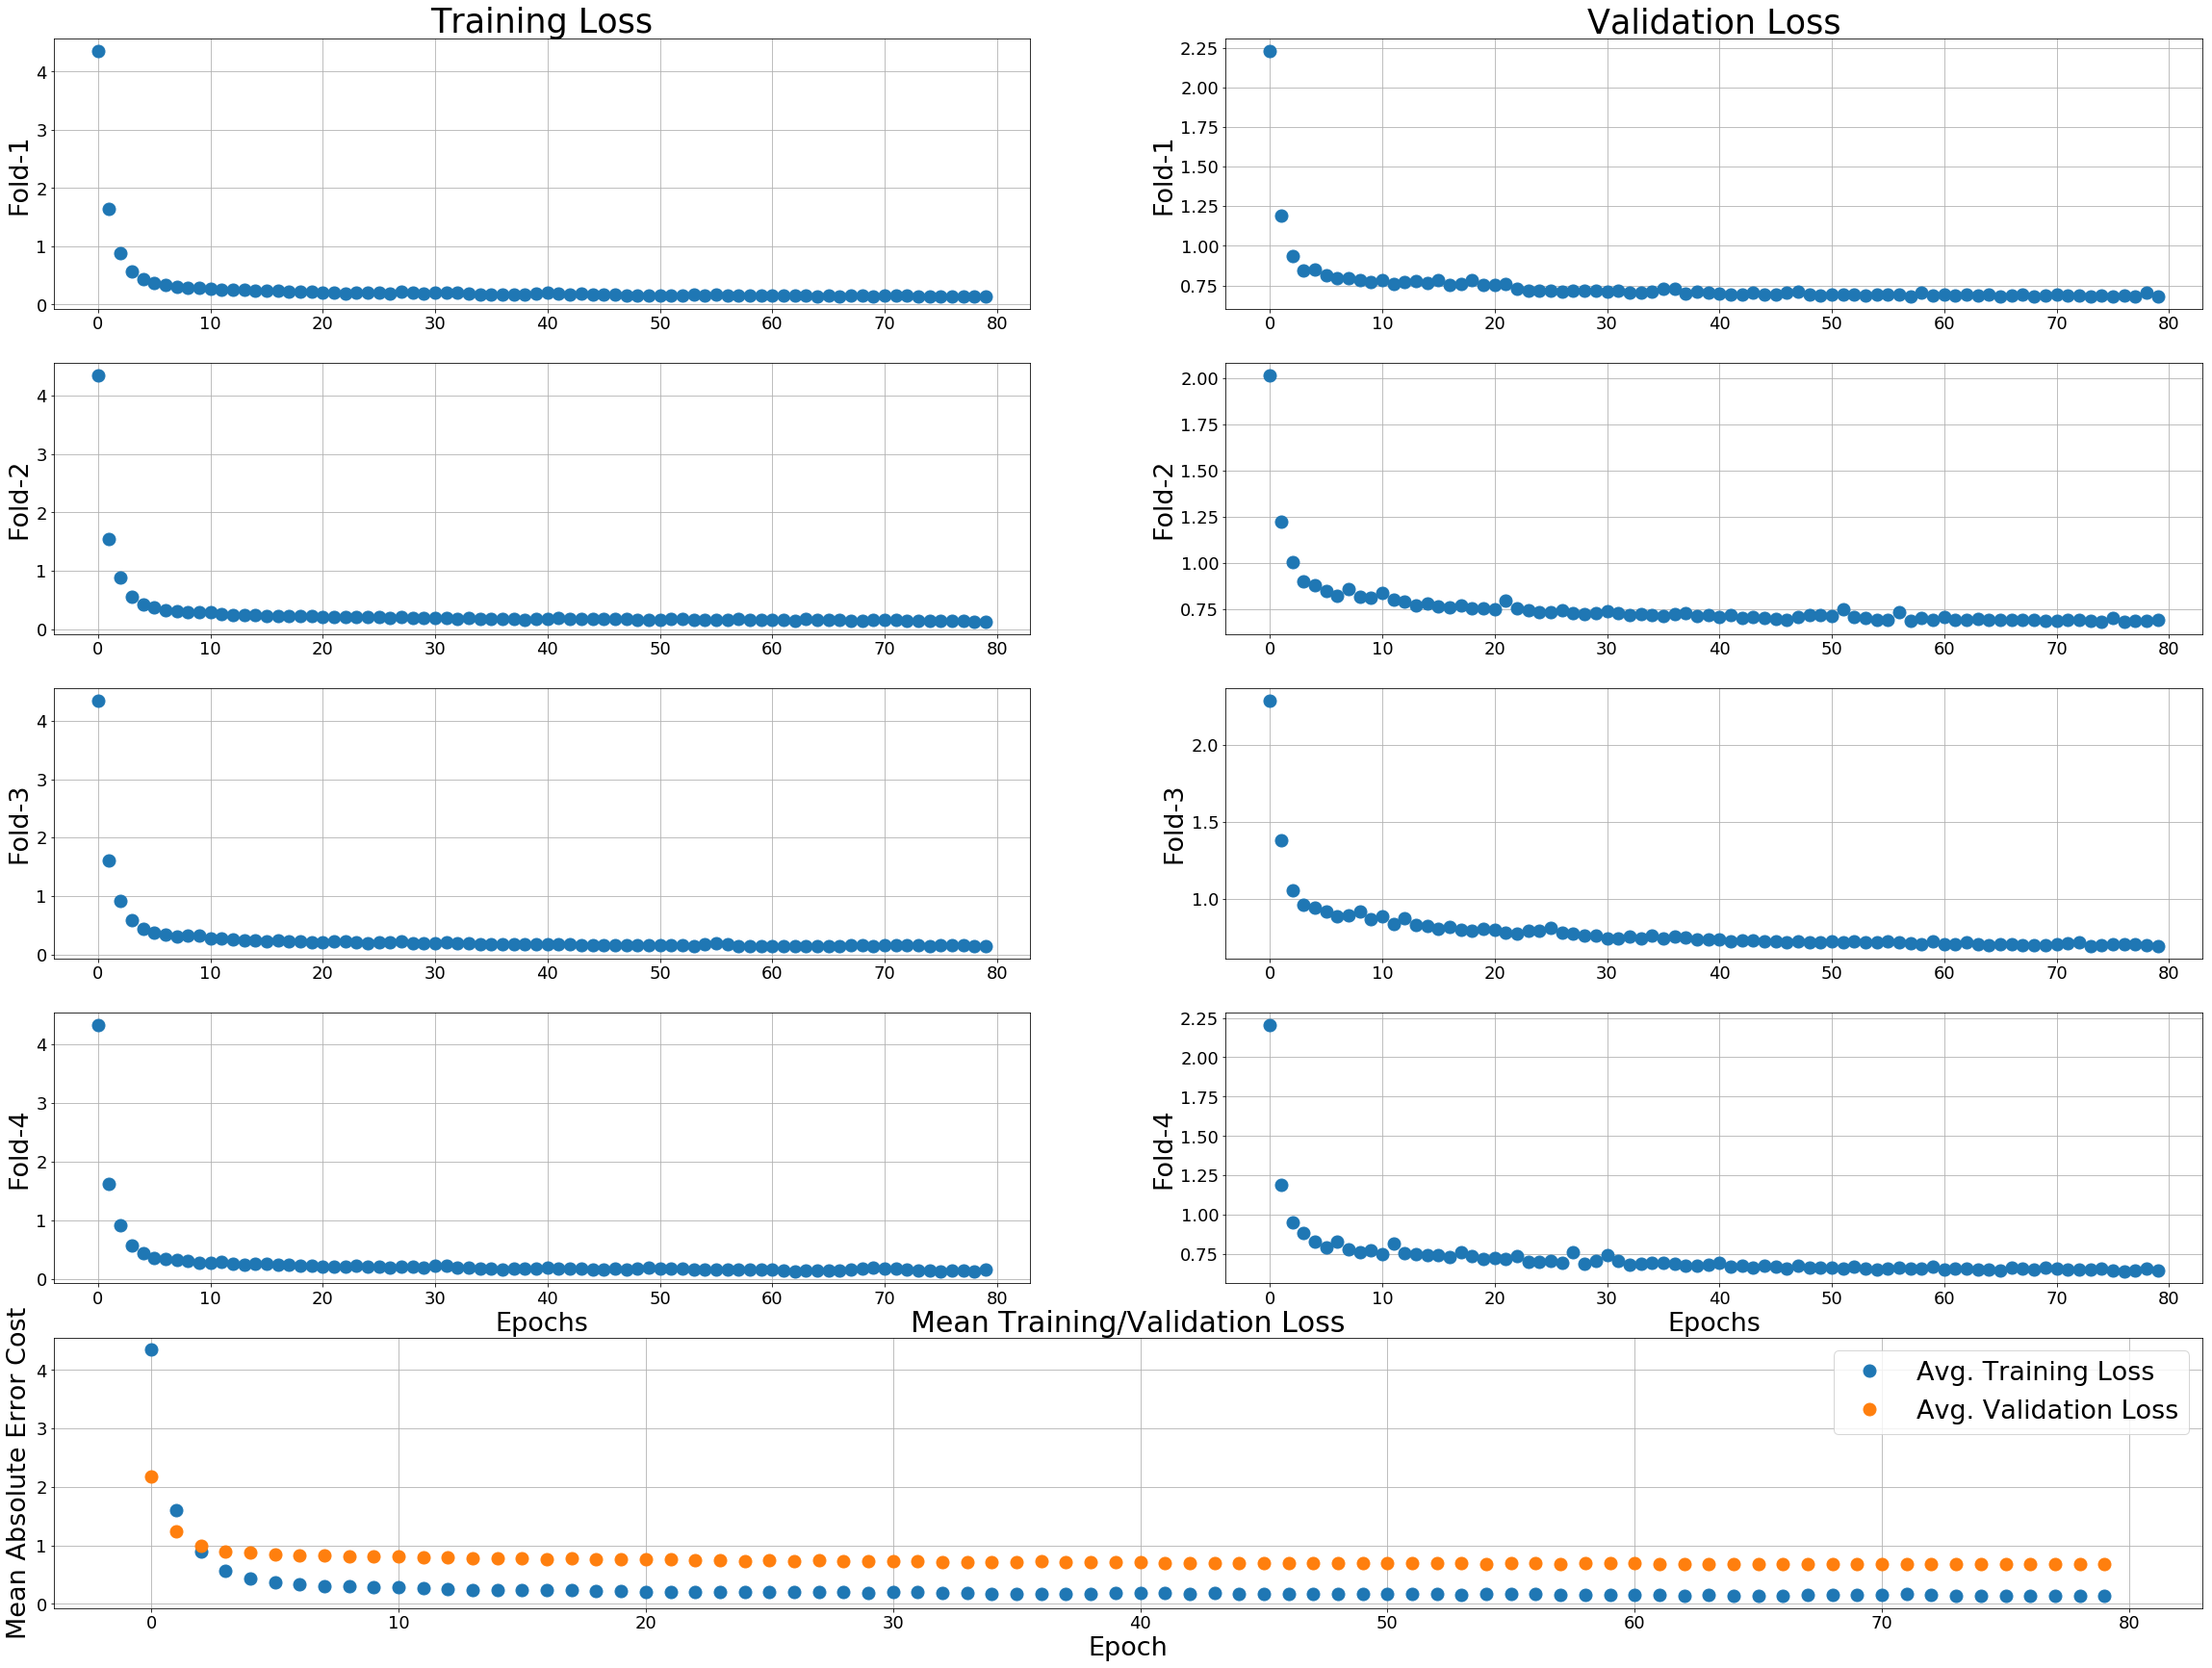

In [24]:
cvScoresHistory = np.asarray(cvScoresHistory)
meanTrainingLossHistory, meanValidationLossHistory = plotCrossValScores(cvScoresHistory, folds, num_epochs)

In [25]:
ind = np.lexsort( (meanTrainingLossHistory, meanValidationLossHistory) )
print('"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss\n')
print(ind)

print("\nTherefore, Epoch:" + str(ind[0]) + " would be a good place to stop training this model.")

"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss

[79 73 76 77 68 65 74 69 75 64 57 71 67 61 63 78 70 72 54 62 66 60 55 53 58
 59 46 45 52 49 48 50 44 42 43 41 56 47 51 40 38 39 37 33 32 35 34 36 28 31
 29 26 30 24 23 25 27 22 20 19 21 16 18 17 15 14 13 12 11  9 10  8  7  6  5
  4  3  2  1  0]

Therefore, Epoch:79 would be a good place to stop training this model.


### But Does the Model Really Work?

To test this question, artificial data was created in which we cast only 1 of our crew members per movie. In other words, we create 1 movie for every director/producer in our "distinctCrew" array, and in each movie we only cast the corresponding cast member.

Using this array of data and a trained model, we can apply these artifical movies to our regression model and predict the ratings for these fake movies. From these fake movies we can sort their ratings from greatest to least and view who the "top choices" would be to get the highest voter rating average.

In [26]:
Xset = []
for i in range(0, len(distinctCrew)):
    Xcurr = np.zeros((1,X.shape[1]))
    Xcurr[0,i] = 1
    Xset.append(Xcurr)
    

predictions = []
for crewMember in Xset:
    predictions.append(float(model.predict(crewMember)))

idx = np.argsort(predictions)

In [27]:
dList = list(distinctCrew)

print('The best choices to make if you were to a cast only one "top" crew member would be:\n')
for i in idx[-1:-20:-1]:
    print(list(dList)[i])

The best choices to make if you were to a cast only one "top" crew member would be:

Stanley Kubrick
Martin Scorsese
James Cameron
Frank Darabont
Sergio Leone
Christopher Nolan
Lasse Hallstr\u00f6m
Frank Capra
Steven Spielberg
Barry Mendel
James Mangold
David Heyman
David Lynch
Joe Wright
Kevin Feige
Alfred Hitchcock
Guillermo del Toro
Gary Barber
Billy Wilder


Given the state of the film industry today, the names that this model was able extrapolate are of various directors/producers who have worked on a lot of critically and commercially successful films, such as Stanley Kubrick, Martin Scorsese, James Cameron, Christopher Nolan, etc.

# REPEAT NOW: Create Rating Regression Model Based Only On Genres

In [28]:
X = createFeatures('genres')
Xnorm = normalize(X, axis = 0, norm = 'l2')

In [29]:
num_epochs = 80

# K*Epoch array for storing training/validation loss history for each random fold
cvScoresHistory = []

for k, (train, test) in enumerate(kfold.split(Xnorm, y)):
    model = Sequential() # feed-forward network instantiation
    
    # 1st fully-connected dense layer (input data encounters this)
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu', input_dim=X.shape[1]))
    
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu')) # 2nd fully-connected layer
    model.add(Dense(units=128, kernel_initializer= initialWeights, activation = 'relu')) # 3rd .. .. .. .. ..
    
    # Final fully-connected layer ("y-hat")
    model.add(Dense(units=1, kernel_initializer= initialWeights, activation = 'relu'))
    
    # loss function and optimization technique specification for model
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    
    # loss-history callback instantiation
    history = LossHistory()
    
    # begin training
    model.fit(Xnorm[train], 
              y[train], 
              validation_data = (Xnorm[test],y[test]), 
              epochs=num_epochs, 
              batch_size=64, 
              verbose=1, 
              callbacks = [history]
             )
    
    # append current training and validation loss history for current fold
    cvScoresHistory.append(history.losses)

Train on 1726 samples, validate on 576 samples
Epoch 1/80
1726/1726 [==============================] - 0s - loss: 5.3312 - val_loss: 1.3547
Epoch 2/80
1726/1726 [==============================] - 0s - loss: 0.9300 - val_loss: 0.7346
Epoch 3/80
1726/1726 [==============================] - 0s - loss: 0.6511 - val_loss: 0.6250
Epoch 4/80
1726/1726 [==============================] - 0s - loss: 0.6065 - val_loss: 0.5981
Epoch 5/80
1726/1726 [==============================] - 0s - loss: 0.5901 - val_loss: 0.6000
Epoch 6/80
1726/1726 [==============================] - 0s - loss: 0.5816 - val_loss: 0.5773
Epoch 7/80
1726/1726 [==============================] - 0s - loss: 0.5682 - val_loss: 0.5736
Epoch 8/80
1726/1726 [==============================] - 0s - loss: 0.5676 - val_loss: 0.5789
Epoch 9/80
1726/1726 [==============================] - 0s - loss: 0.5776 - val_loss: 0.5847
Epoch 10/80
1726/1726 [==============================] - 0s - loss: 0.5665 - val_loss: 0.5754
Epoch 11/80
1726/1726 

1726/1726 [==============================] - 0s - loss: 0.5709 - val_loss: 0.5716
Epoch 8/80
1726/1726 [==============================] - 0s - loss: 0.5814 - val_loss: 0.5617
Epoch 9/80
1726/1726 [==============================] - 0s - loss: 0.5696 - val_loss: 0.5556
Epoch 10/80
1726/1726 [==============================] - 0s - loss: 0.5684 - val_loss: 0.5785
Epoch 11/80
1726/1726 [==============================] - 0s - loss: 0.5700 - val_loss: 0.5558
Epoch 12/80
1726/1726 [==============================] - 0s - loss: 0.5619 - val_loss: 0.5542
Epoch 13/80
1726/1726 [==============================] - 0s - loss: 0.5667 - val_loss: 0.5611
Epoch 14/80
1726/1726 [==============================] - 0s - loss: 0.5622 - val_loss: 0.5579
Epoch 15/80
1726/1726 [==============================] - 0s - loss: 0.5622 - val_loss: 0.5547
Epoch 16/80
1726/1726 [==============================] - 0s - loss: 0.5617 - val_loss: 0.5567
Epoch 17/80
1726/1726 [==============================] - 0s - loss: 0.5612

1727/1727 [==============================] - 0s - loss: 0.5504 - val_loss: 0.5898
Epoch 14/80
1727/1727 [==============================] - 0s - loss: 0.5574 - val_loss: 0.5943
Epoch 15/80
1727/1727 [==============================] - 0s - loss: 0.5557 - val_loss: 0.6044
Epoch 16/80
1727/1727 [==============================] - 0s - loss: 0.5567 - val_loss: 0.5855
Epoch 17/80
1727/1727 [==============================] - 0s - loss: 0.5523 - val_loss: 0.5838
Epoch 18/80
1727/1727 [==============================] - 0s - loss: 0.5507 - val_loss: 0.5901
Epoch 19/80
1727/1727 [==============================] - 0s - loss: 0.5512 - val_loss: 0.5865
Epoch 20/80
1727/1727 [==============================] - 0s - loss: 0.5511 - val_loss: 0.5845
Epoch 21/80
1727/1727 [==============================] - 0s - loss: 0.5460 - val_loss: 0.5919
Epoch 22/80
1727/1727 [==============================] - 0s - loss: 0.5482 - val_loss: 0.6295
Epoch 23/80
1727/1727 [==============================] - 0s - loss: 0.55

1727/1727 [==============================] - 0s - loss: 0.5723 - val_loss: 0.5562
Epoch 20/80
1727/1727 [==============================] - 0s - loss: 0.5635 - val_loss: 0.5732
Epoch 21/80
1727/1727 [==============================] - 0s - loss: 0.5660 - val_loss: 0.5579
Epoch 22/80
1727/1727 [==============================] - 0s - loss: 0.5607 - val_loss: 0.5887
Epoch 23/80
1727/1727 [==============================] - 0s - loss: 0.5584 - val_loss: 0.5555
Epoch 24/80
1727/1727 [==============================] - 0s - loss: 0.5495 - val_loss: 0.5749
Epoch 25/80
1727/1727 [==============================] - 0s - loss: 0.5529 - val_loss: 0.6097
Epoch 26/80
1727/1727 [==============================] - 0s - loss: 0.5777 - val_loss: 0.6219
Epoch 27/80
1727/1727 [==============================] - 0s - loss: 0.5904 - val_loss: 0.5829
Epoch 28/80
1727/1727 [==============================] - 0s - loss: 0.5617 - val_loss: 0.5618
Epoch 29/80
1727/1727 [==============================] - 0s - loss: 0.55

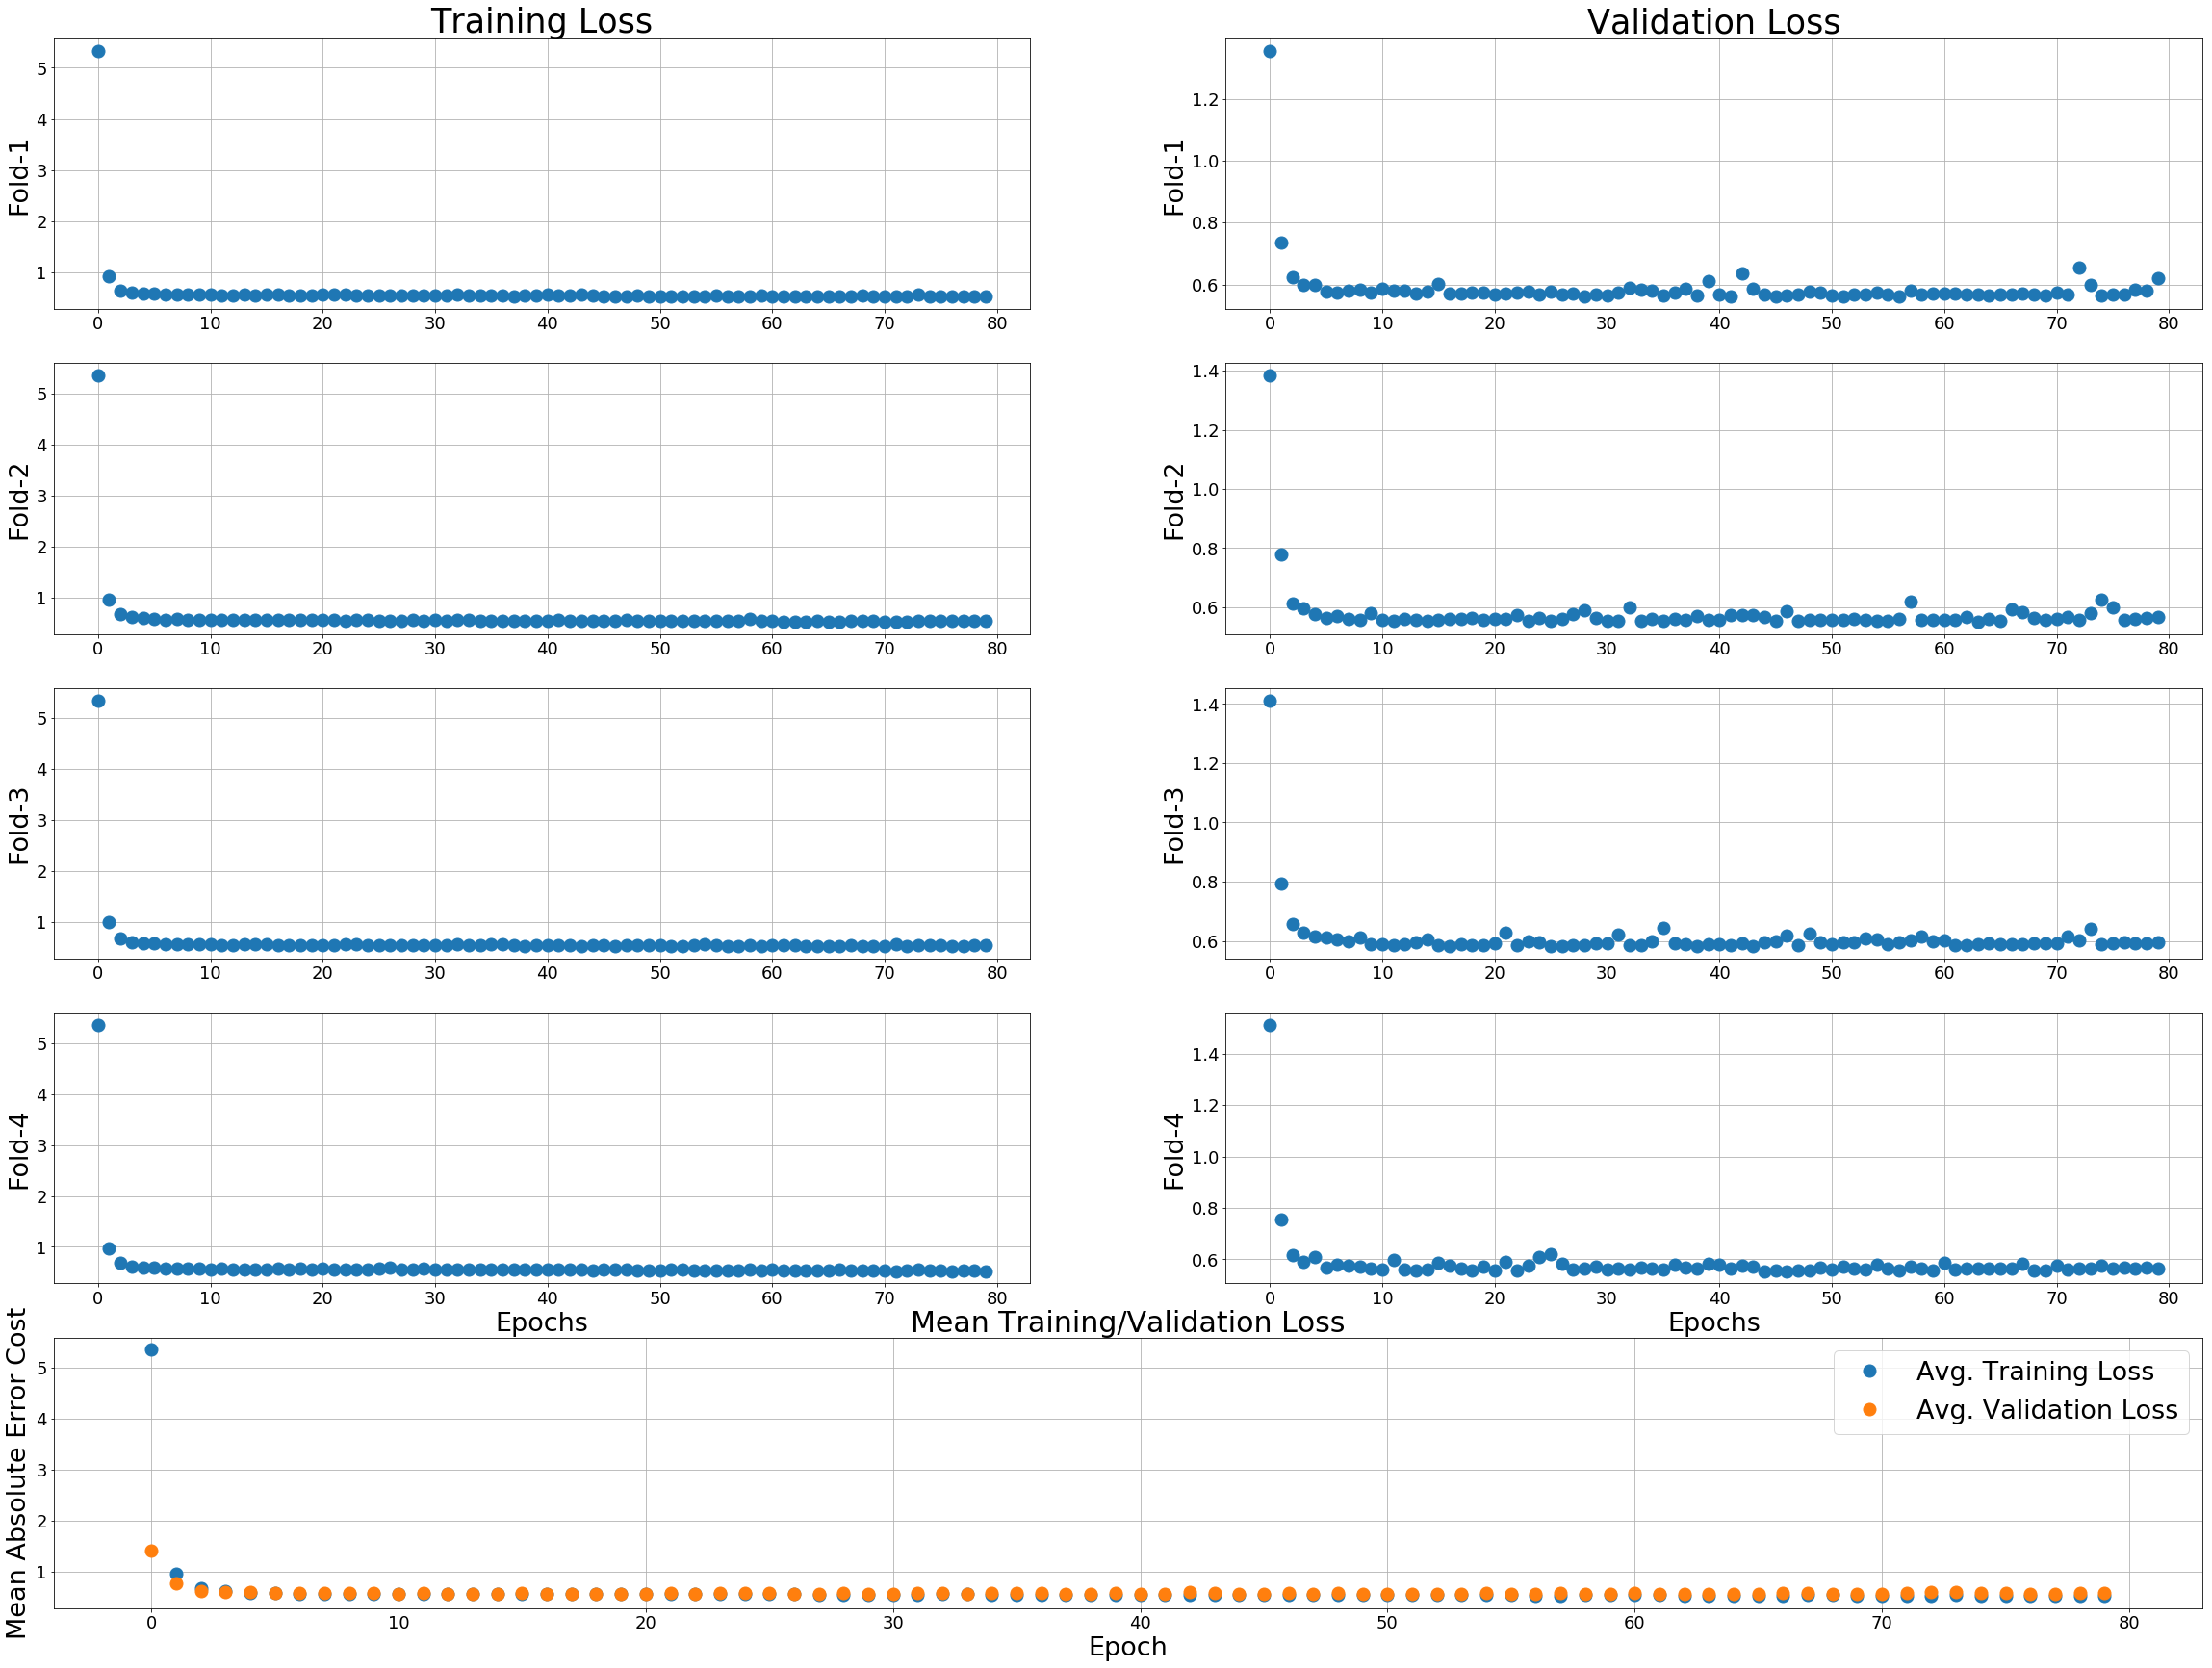

In [30]:
cvScoresHistory = np.asarray(cvScoresHistory)
meanTrainingLossHistory, meanValidationLossHistory = plotCrossValScores(cvScoresHistory, folds, num_epochs)

In [31]:
ind = np.lexsort( (meanTrainingLossHistory, meanValidationLossHistory) )
print('"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss\n')
print(ind)

print("\nTherefore, Epoch:" + str(ind[0]) + " would be a good place to stop training this model.")

"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss

[47 69 45 50 63 30 55 56 61 65 20 18 64 38 13 59 68 17 51 62 41 52 44 19 22
 76 16 10 29 40 33 53 12 49 26 27 14 37 77 70 58 28 34 78 23 36  9 71 54  7
 66 31 48 43 11 60  5 75 46  8 35 67  6 15 32 25 24 39 79 21 74 57 72 42 73
  4  3  2  1  0]

Therefore, Epoch:47 would be a good place to stop training this model.


### But Does the Model Really Work?

To test this question, artificial data was created in which we only have 1 of these genres per movie. In other words, we create 1 movie for every genre in our "distinctGenres" array.

Using this array of data and a trained model, we can apply these artifical movies to our regression model and predict the ratings for these fake movies. From these fake movies we can sort their ratings from greatest to least and view what the "top choices" would be to get the highest voter rating average.

In [32]:
Xset = []
for i in range(0, len(distinctGenres)):
    Xcurr = np.zeros((1,X.shape[1]))
    Xcurr[0,i] = 1
    Xset.append(Xcurr)
    

predictions = []
for genre in Xset:
    predictions.append(float(model.predict(genre)))

idx = np.argsort(predictions)

In [33]:
dList = list(distinctGenres)

print('The best choices to make if you were to a cast only one top genre would be:\n')
for i in idx[-1::-1]:
    print(list(dList)[i])

The best choices to make if you were to a cast only one top genre would be:

Animation
Mystery
War
Western
Crime
Music
Romance
Science Fiction
History
Fantasy
Drama
Documentary
Family
Thriller
Adventure
Action
Comedy
Horror
TV Movie


Given the state of the film industry today, the order of genres that this model was able extrapolate corresponds to the critical and commercial success of our times today. Star Wars for example, contains the top 4 genres and can fit under the genres of:
- Mystery
- Romance
- Animation
- War
- Drama
- Fantasy
- and more.

# REPEAT NOW: Create Rating Regression Model Based Only On Production Companies

In [34]:
X = createFeatures('prod')
Xnorm = normalize(X, axis = 0, norm = 'l2')

In [35]:
num_epochs = 80

# K*Epoch array for storing training/validation loss history for each random fold
cvScoresHistory = []

for k, (train, test) in enumerate(kfold.split(Xnorm, y)):
    model = Sequential() # feed-forward network instantiation
    
    # 1st fully-connected dense layer (input data encounters this)
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu', input_dim=X.shape[1]))
    
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu')) # 2nd fully-connected layer
    model.add(Dense(units=128, kernel_initializer= initialWeights, activation = 'relu')) # 3rd .. .. .. .. ..
    
    # Final fully-connected layer ("y-hat")
    model.add(Dense(units=1, kernel_initializer= initialWeights, activation = 'relu'))
    
    # loss function and optimization technique specification for model
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    
    # loss-history callback instantiation
    history = LossHistory()
    
    # begin training
    model.fit(Xnorm[train], 
              y[train], 
              validation_data = (Xnorm[test],y[test]), 
              epochs=num_epochs, 
              batch_size=64, 
              verbose=1, 
              callbacks = [history]
             )
    
    # append current training and validation loss history for current fold
    cvScoresHistory.append(history.losses)

Train on 1726 samples, validate on 576 samples
Epoch 1/80
1726/1726 [==============================] - 0s - loss: 4.5461 - val_loss: 2.3411
Epoch 2/80
1726/1726 [==============================] - 0s - loss: 1.7967 - val_loss: 1.1947
Epoch 3/80
1726/1726 [==============================] - 0s - loss: 0.8717 - val_loss: 0.8444
Epoch 4/80
1726/1726 [==============================] - 0s - loss: 0.5512 - val_loss: 0.7580
Epoch 5/80
1726/1726 [==============================] - 0s - loss: 0.4588 - val_loss: 0.7420
Epoch 6/80
1726/1726 [==============================] - 0s - loss: 0.4094 - val_loss: 0.7396
Epoch 7/80
1726/1726 [==============================] - 0s - loss: 0.3816 - val_loss: 0.7602
Epoch 8/80
1726/1726 [==============================] - 0s - loss: 0.3680 - val_loss: 0.7656
Epoch 9/80
1726/1726 [==============================] - 0s - loss: 0.3610 - val_loss: 0.7517
Epoch 10/80
1726/1726 [==============================] - 0s - loss: 0.3436 - val_loss: 0.7339
Epoch 11/80
1726/1726 

1726/1726 [==============================] - 0s - loss: 0.3674 - val_loss: 0.7931
Epoch 8/80
1726/1726 [==============================] - 0s - loss: 0.3546 - val_loss: 0.8189
Epoch 9/80
1726/1726 [==============================] - 0s - loss: 0.3502 - val_loss: 0.7788
Epoch 10/80
1726/1726 [==============================] - 0s - loss: 0.3493 - val_loss: 0.8085
Epoch 11/80
1726/1726 [==============================] - 0s - loss: 0.3235 - val_loss: 0.8355
Epoch 12/80
1726/1726 [==============================] - 0s - loss: 0.3339 - val_loss: 0.8354
Epoch 13/80
1726/1726 [==============================] - 0s - loss: 0.3111 - val_loss: 0.8132
Epoch 14/80
1726/1726 [==============================] - 0s - loss: 0.3296 - val_loss: 0.7751
Epoch 15/80
1726/1726 [==============================] - 0s - loss: 0.3340 - val_loss: 0.8319
Epoch 16/80
1726/1726 [==============================] - 0s - loss: 0.3083 - val_loss: 0.7876
Epoch 17/80
1726/1726 [==============================] - 0s - loss: 0.2946

1727/1727 [==============================] - 0s - loss: 0.3107 - val_loss: 0.7494
Epoch 14/80
1727/1727 [==============================] - 0s - loss: 0.3122 - val_loss: 0.7567
Epoch 15/80
1727/1727 [==============================] - 0s - loss: 0.2946 - val_loss: 0.7568
Epoch 16/80
1727/1727 [==============================] - 0s - loss: 0.3054 - val_loss: 0.7763
Epoch 17/80
1727/1727 [==============================] - 0s - loss: 0.2995 - val_loss: 0.7426
Epoch 18/80
1727/1727 [==============================] - 0s - loss: 0.2956 - val_loss: 0.7384
Epoch 19/80
1727/1727 [==============================] - 0s - loss: 0.2868 - val_loss: 0.7423
Epoch 20/80
1727/1727 [==============================] - 0s - loss: 0.2859 - val_loss: 0.7387
Epoch 21/80
1727/1727 [==============================] - 0s - loss: 0.2824 - val_loss: 0.7388
Epoch 22/80
1727/1727 [==============================] - 0s - loss: 0.2855 - val_loss: 0.7468
Epoch 23/80
1727/1727 [==============================] - 0s - loss: 0.27

1727/1727 [==============================] - 0s - loss: 0.2880 - val_loss: 0.7680
Epoch 20/80
1727/1727 [==============================] - 0s - loss: 0.2978 - val_loss: 0.7605
Epoch 21/80
1727/1727 [==============================] - 0s - loss: 0.2835 - val_loss: 0.7644
Epoch 22/80
1727/1727 [==============================] - 0s - loss: 0.2935 - val_loss: 0.7341
Epoch 23/80
1727/1727 [==============================] - 0s - loss: 0.2841 - val_loss: 0.7411
Epoch 24/80
1727/1727 [==============================] - 0s - loss: 0.2684 - val_loss: 0.7307
Epoch 25/80
1727/1727 [==============================] - 0s - loss: 0.2782 - val_loss: 0.7256
Epoch 26/80
1727/1727 [==============================] - 0s - loss: 0.2753 - val_loss: 0.7295
Epoch 27/80
1727/1727 [==============================] - 0s - loss: 0.2831 - val_loss: 0.7355
Epoch 28/80
1727/1727 [==============================] - 0s - loss: 0.2611 - val_loss: 0.7182
Epoch 29/80
1727/1727 [==============================] - 0s - loss: 0.27

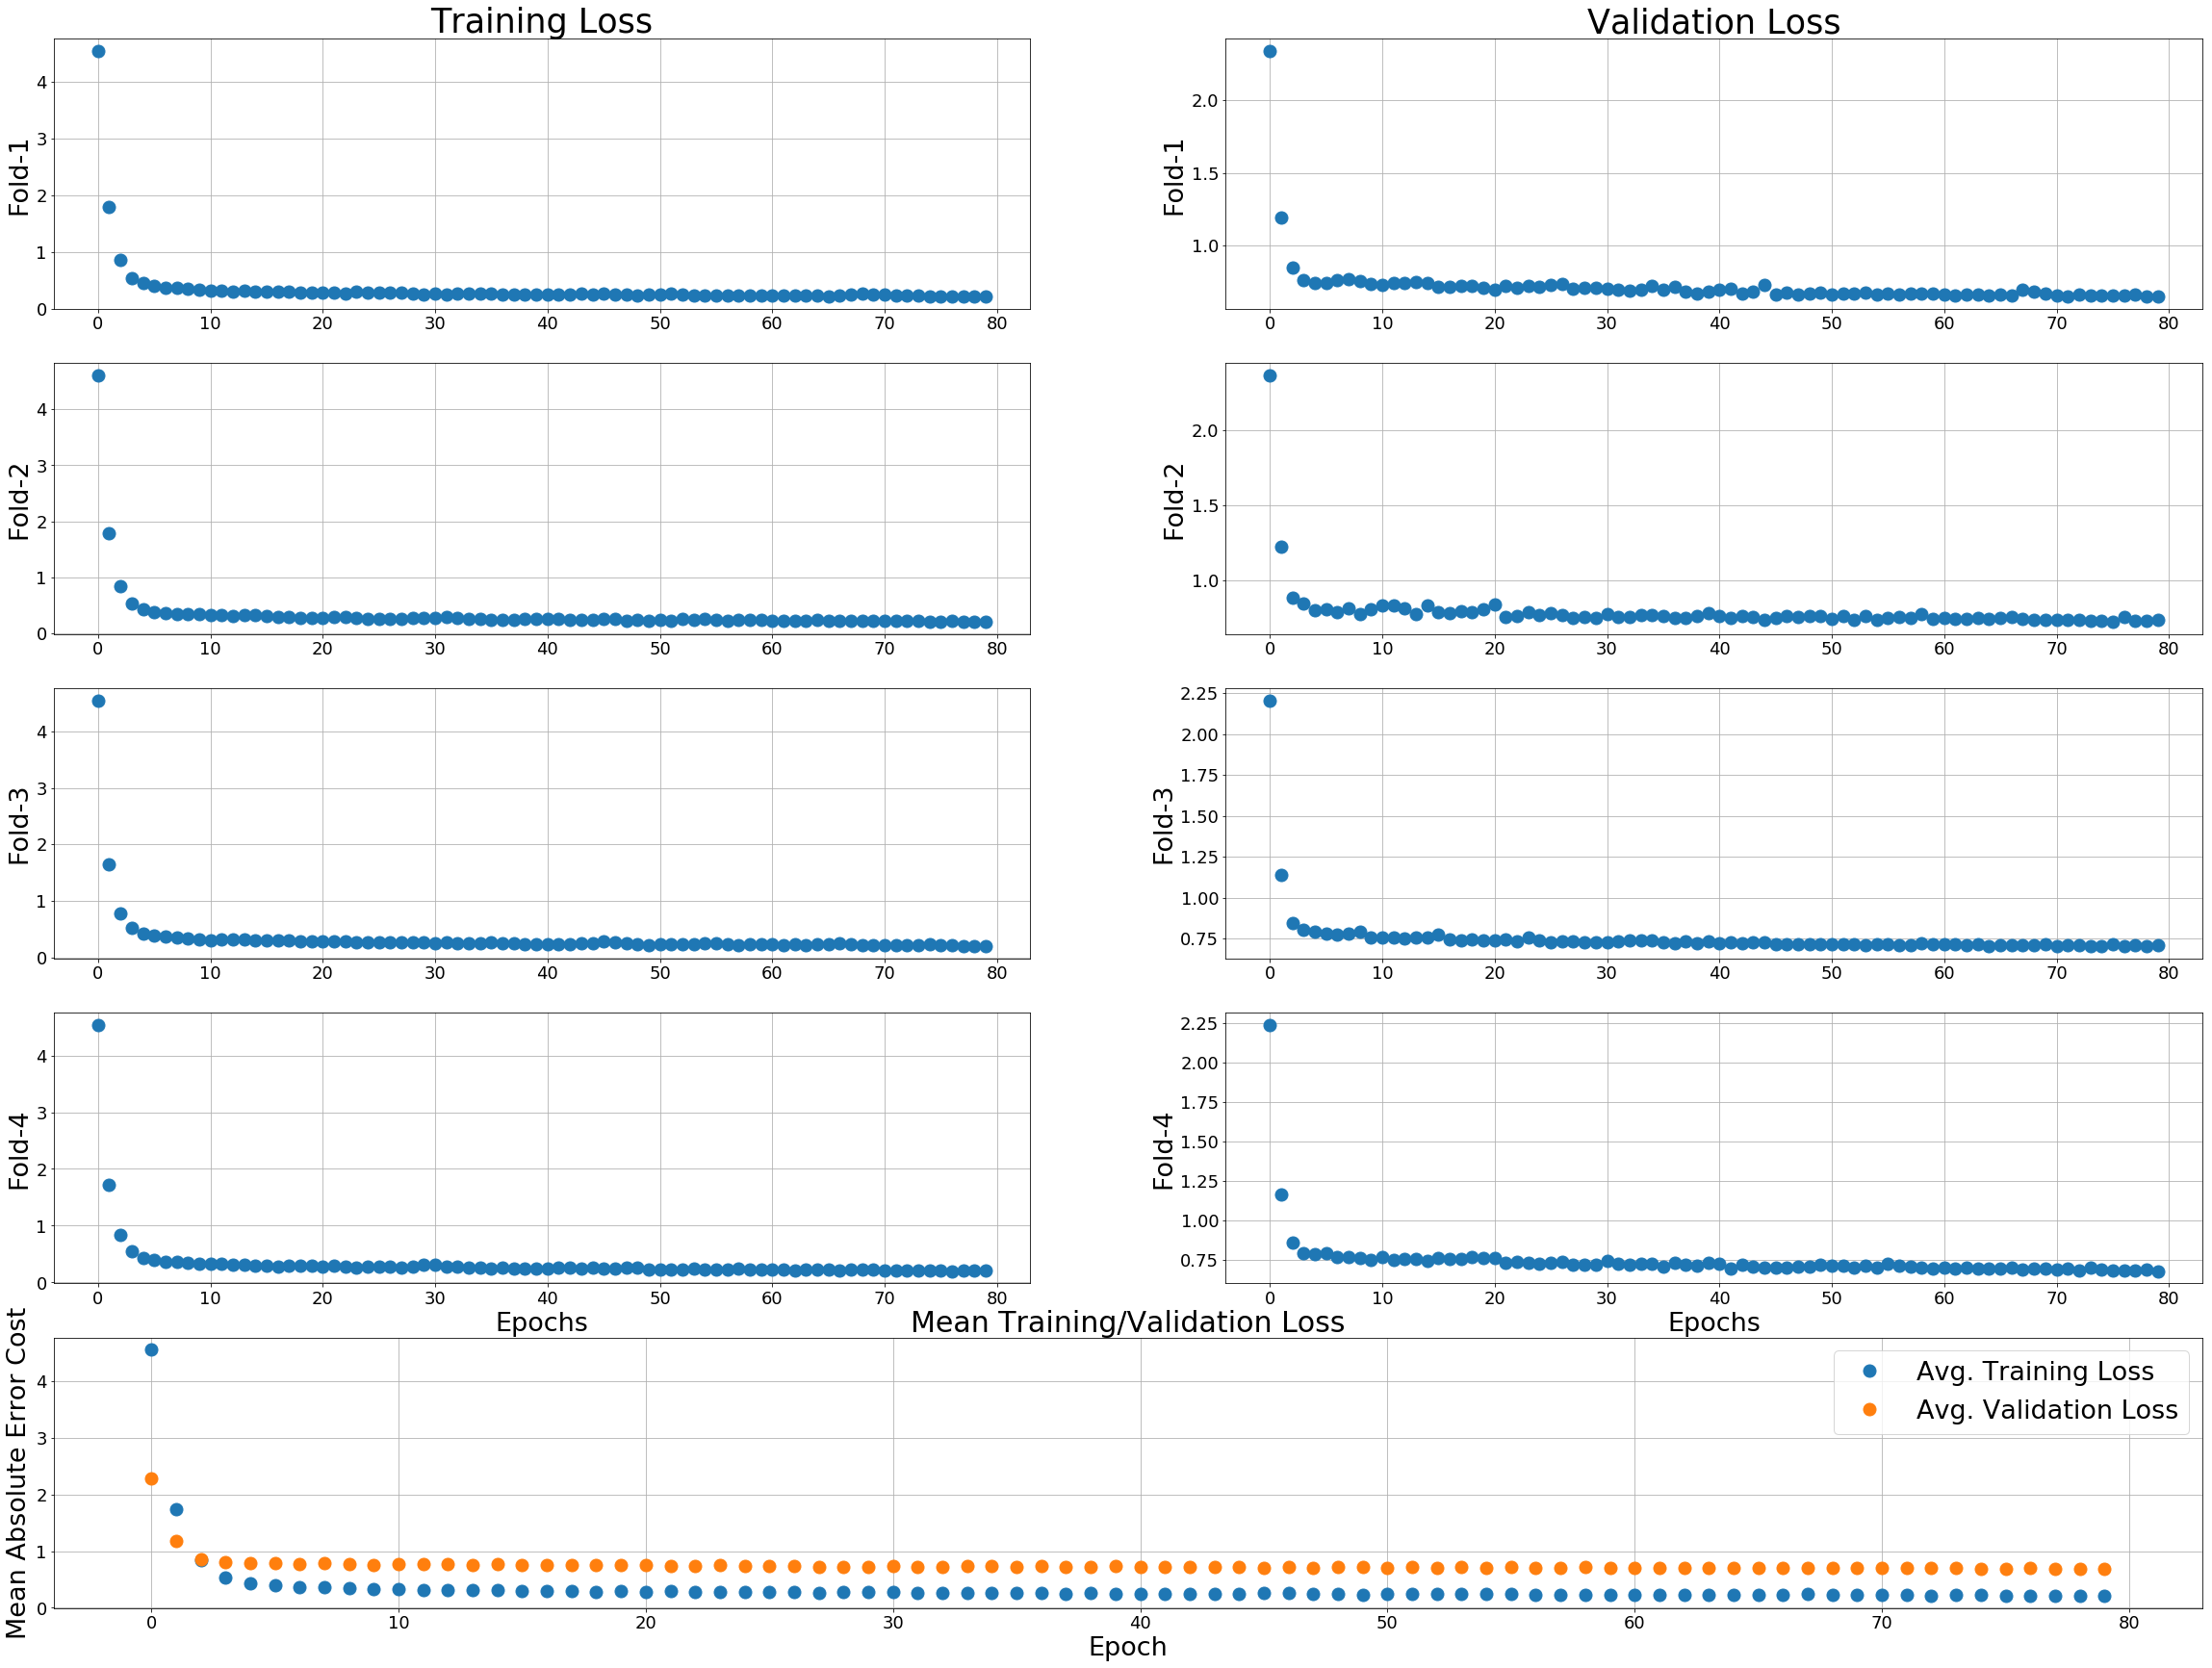

In [36]:
cvScoresHistory = np.asarray(cvScoresHistory)
meanTrainingLossHistory, meanValidationLossHistory = plotCrossValScores(cvScoresHistory, folds, num_epochs)

In [37]:
ind = np.lexsort( (meanTrainingLossHistory, meanValidationLossHistory) )
print('"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss\n')
print(ind)

print("\nTherefore, Epoch:" + str(ind[0]) + " would be a good place to stop training this model.")

"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss

[78 79 75 77 74 70 72 73 71 76 64 61 62 65 54 69 68 59 63 52 66 60 45 50 57
 67 47 56 48 46 53 51 58 55 38 41 42 43 49 37 44 35 40 32 29 27 28 31 36 33
 39 30 22 24 34 21 25 26 16 23 17 18 19 13 15 20  9 12 14  8 11 10  6  5  4
  7  3  2  1  0]

Therefore, Epoch:78 would be a good place to stop training this model.


### But Does the Model Really Work?

To test this question, artificial data was created in which we only have 1 of these production companies per movie. In other words, we create 1 movie for every production company in our "distinctProd" array.

Using this array of data and a trained model, we can apply these artifical movies to our regression model and predict the ratings for these fake movies. From these fake movies we can sort their ratings from greatest to least and view what the "top choices" would be to get the highest voter rating average.

In [38]:
Xset = []
for i in range(0, len(distinctProd)):
    Xcurr = np.zeros((1,X.shape[1]))
    Xcurr[0,i] = 1
    Xset.append(Xcurr)
    

predictions = []
for prod in Xset:
    predictions.append(float(model.predict(prod)))

idx = np.argsort(predictions)

In [39]:
dList = list(distinctProd)

print('The best choices to make if you were to a cast only one "top" production company would be:\n')
for i in idx[-1::-1]:
    print(list(dList)[i])

The best choices to make if you were to a cast only one "top" production company would be:

Warner Bros.
WingNut Films
Syncopy
United Artists
The Weinstein Company
Studio Ghibli
Twentieth Century Fox Film Corporation
Constantin Film Produktion
Winkler Films
Sunswept Entertainment
Pixar Animation Studios
Toho Company
Warner Bros. Animation
Scion Films
Cloud Eight Films
Lucasfilm
Barry Mendel Productions
Castle Rock Entertainment
Paramount Vantage
Blue Parrot Productions
Temple Hill Entertainment
40 Acres & A Mule Filmworks
TriStar Pictures
Studio Canal
U-Drive Productions
Mr. Mudd Production
Jersey Films
Blue Sky Studios
Horizon Pictures (II)
American Empirical Pictures
One Race Productions
Walt Disney Feature Animation
Kurtzman/Orci
Riche-Ludwig Productions
Mutual Film Company
American Zoetrope
Wigram Productions
Alfran Productions
Right of Way Films
GK Films
Paramount Pictures
Heyday Films
Groucho II Film Partnership
Flower Films (II)
Shamley Productions
Selznick International Picture

Swanford Films
Criminal Productions
Four By Two Productions
Fox Animation Studios
Bedlam Productions
Bonne Pioche
Gone North Productions
Euforia Film
Centre National de la Cin\u00e9matographie
Extension 765
Pain Unlimited GmbH Filmproduktion
Cinemarque Entertainment BV
Bee Vine Pictures
Carthago Films S.a.r.l.
Mars Films
Cinematograph A/S
Yucaipa Films
Sofica Sofinergie 5
Solipsist Film
United China Vision
Quarante 12 Films
Indo-British
Miracle Pictures
Ehman Productions
Antena 3 Televisi\u00f3n
Langley Productions
Gambit Pictures
Young Hannibal Productions
Nina Saxon Film Design
Stereo D
Starz Animation
Slap Happy Productions (II)
Twilight Productions
Trademark Films
Disney
Blackfriars Bridge Films
Curmudgeon Films
Golden Harvest Company
Warner Bros. Family Entertainment
Yellow Bird
Seed Productions
Flyboys Films
Osiris Films
Da Vinci Media Ventures
Jerico
United Broadcasting Inc.
SW7D Productions
Brooklyn Films II
Sony Pictures
Broad Green Pictures
PIC Agency
Fireworks Pictures
Ecoss

Beagle Pug Films
Alphaville Films
Dragonfly Entertainment
Inside Track 3
Alta Loma Entertainment
Jason Productions
Onda Entertainment
Sneaky Shark
Kino Vision
The Canton Company
Sierra / Affinity
Moving Pictures
Evansgideon/Lazar
Future Films
Panorama Media
Hasbro Studios
Kanzeon
Paramount Animation
Gold Circle Films
Twisted Pictures
OddLot Entertainment
Dylan Sellers Productions
Riche Productions
Perdido Prod.
Beacon Communications
LD Entertainment
Location Gourmet
WR Universal Group
Sullivan Bluth Studios
Reaper Productions
Silver Plane Films
Legend3D
Golden Mean
Rickshaw Productions
Silverbell Films
Caravan Pictures
Pandemonium Productions
Amazon Prime Instant Video
Millennium Films
Destiny
France 2 Cin\u00e9ma
Close Call Films
Denver and Delilah Productions
France T\u00e9l\u00e9visions
Black & White Productions
Iron Fists
Village Roadshow Films North America
St. Tropez Films
Wonder works studios entertainment group
Storefront Pictures
Wonderland Sound and Vision
Gratitude Internati

Given the state of the film industry today, the order of production companies that this model was able extrapolate corresponds to the critical and commercial success of our times today. For example, names such as:
- Warner Bros
- Syncopy
- WingNut Films
- United Artists
- The Weinstein COmpany
- Twentieth Century Fox
- and more.

# Last And Final Interesting Thing to Attempt: 
## Create Model That Uses All of These Modalities

Time to try to add layers for each of these modalities into one combined network.

In [40]:
# create arrays for seperate modalities
Xb = createFeatures('budget')
Xca = createFeatures('cast')
Xcr = createFeatures('crew')
Xg = createFeatures('genres')
Xp = createFeatures('prod')

# normalize each modality respectively
Xb_norm = normalize(Xb, axis = 0, norm = 'l2')
Xca_norm = normalize(Xca, axis = 0, norm = 'l2')
Xcr_norm = normalize(Xcr, axis = 0, norm = 'l2')
Xg_norm = normalize(Xg, axis = 0, norm = 'l2')
Xp_norm = normalize(Xp, axis = 0, norm = 'l2')

In [41]:
num_epochs = 80
cvScoresHistory = []

for k, (train, test) in enumerate(kfold.split(Xnorm, y)):
    
    # budget branch
    budgetInput = Input(shape = (Xb.shape[1],))
    budgetBranch = Dense(units = 64, kernel_initializer = initialWeights, activation='relu')(budgetInput)
    budgetBranch = Dense(units = 32, kernel_initializer = initialWeights, activation='relu')(budgetBranch)
    budgetBranch = BatchNormalization()(budgetBranch)
    
    # cast branch
    castInput = Input(shape = (Xca.shape[1],))
    castBranch = Dense(units = 64, kernel_initializer = initialWeights, activation='relu')(castInput)
    castBranch = Dense(units = 32, kernel_initializer = initialWeights, activation='relu')(castBranch)
    castBranch = BatchNormalization()(castBranch)
    
    # crew branch
    crewInput = Input(shape = (Xcr.shape[1],))
    crewBranch = Dense(units = 64, kernel_initializer = initialWeights, activation='relu')(crewInput)
    crewBranch = Dense(units = 32, kernel_initializer = initialWeights, activation='relu')(crewBranch)
    crewBranch = BatchNormalization()(crewBranch)
    
    # genre branch
    genreInput = Input(shape = (Xg.shape[1],))
    genreBranch = Dense(units = 64, kernel_initializer = initialWeights, activation='relu')(genreInput)
    genreBranch = Dense(units = 32, kernel_initializer = initialWeights, activation='relu')(genreBranch)
    genreBranch = BatchNormalization()(genreBranch)
    
    # production branch
    prodInput = Input(shape = (Xp.shape[1],))
    prodBranch = Dense(units = 64, kernel_initializer = initialWeights, activation='relu')(prodInput)
    prodBranch = Dense(units = 32, kernel_initializer = initialWeights, activation='relu')(prodBranch)
    prodBranch = BatchNormalization()(prodBranch)
    
    # added combine all the layers into one added network by adding an "add-layer"
    added = add([budgetBranch, castBranch, crewBranch, genreBranch, prodBranch])
    out = Dense(units = 1, kernel_initializer = initialWeights, activation='relu')(added)
    
    model = keras.models.Model(inputs = [budgetInput, castInput, crewInput, genreInput, prodInput], outputs = out)
    model.compile(loss='mean_absolute_error',optimizer = 'adam')
    
    history = LossHistory()
    model.fit(
        [Xb_norm[train], Xca_norm[train], Xcr_norm[train], Xg_norm[train], Xp_norm[train]], y[train],
        validation_data = ([Xb_norm[test], Xca_norm[test], Xcr_norm[test], Xg_norm[test], Xp_norm[test]], y[test]),
        epochs=num_epochs,
        batch_size=64,
        verbose=1,
        callbacks = [history]
    )
    
    cvScoresHistory.append(history.losses)

Train on 1726 samples, validate on 576 samples
Epoch 1/80
1726/1726 [==============================] - 1s - loss: 6.1257 - val_loss: 6.0104
Epoch 2/80
1726/1726 [==============================] - 0s - loss: 5.1187 - val_loss: 5.2215
Epoch 3/80
1726/1726 [==============================] - 0s - loss: 4.2654 - val_loss: 4.5797
Epoch 4/80
1726/1726 [==============================] - 0s - loss: 3.7632 - val_loss: 4.1723
Epoch 5/80
1726/1726 [==============================] - 0s - loss: 3.4927 - val_loss: 3.8273
Epoch 6/80
1726/1726 [==============================] - 0s - loss: 3.2269 - val_loss: 3.2939
Epoch 7/80
1726/1726 [==============================] - 0s - loss: 2.8749 - val_loss: 2.7114
Epoch 8/80
1726/1726 [==============================] - 0s - loss: 2.4091 - val_loss: 2.0557
Epoch 9/80
1726/1726 [==============================] - 0s - loss: 1.7995 - val_loss: 0.9595
Epoch 10/80
1726/1726 [==============================] - 0s - loss: 1.1513 - val_loss: 0.6214
Epoch 11/80
1726/1726 

1726/1726 [==============================] - 0s - loss: 2.7943 - val_loss: 2.4784
Epoch 8/80
1726/1726 [==============================] - 0s - loss: 2.3120 - val_loss: 1.8066
Epoch 9/80
1726/1726 [==============================] - 0s - loss: 1.7538 - val_loss: 1.0787
Epoch 10/80
1726/1726 [==============================] - 0s - loss: 1.0541 - val_loss: 0.6329
Epoch 11/80
1726/1726 [==============================] - 0s - loss: 0.5870 - val_loss: 0.6468
Epoch 12/80
1726/1726 [==============================] - 0s - loss: 0.3597 - val_loss: 0.6574
Epoch 13/80
1726/1726 [==============================] - 0s - loss: 0.2926 - val_loss: 0.6368
Epoch 14/80
1726/1726 [==============================] - 0s - loss: 0.2490 - val_loss: 0.6476
Epoch 15/80
1726/1726 [==============================] - 0s - loss: 0.2205 - val_loss: 0.6294
Epoch 16/80
1726/1726 [==============================] - 0s - loss: 0.2094 - val_loss: 0.6150
Epoch 17/80
1726/1726 [==============================] - 0s - loss: 0.1991

1727/1727 [==============================] - 0s - loss: 0.2639 - val_loss: 0.6986ss
Epoch 14/80
1727/1727 [==============================] - 0s - loss: 0.2408 - val_loss: 0.6474
Epoch 15/80
1727/1727 [==============================] - 0s - loss: 0.2111 - val_loss: 0.6430
Epoch 16/80
1727/1727 [==============================] - 0s - loss: 0.2039 - val_loss: 0.6369
Epoch 17/80
1727/1727 [==============================] - 0s - loss: 0.1843 - val_loss: 0.6331
Epoch 18/80
1727/1727 [==============================] - 0s - loss: 0.2088 - val_loss: 0.6255
Epoch 19/80
1727/1727 [==============================] - 0s - loss: 0.1703 - val_loss: 0.6140
Epoch 20/80
1727/1727 [==============================] - 0s - loss: 0.1764 - val_loss: 0.6110
Epoch 21/80
1727/1727 [==============================] - 0s - loss: 0.1640 - val_loss: 0.6089
Epoch 22/80
1727/1727 [==============================] - 0s - loss: 0.1584 - val_loss: 0.6087
Epoch 23/80
1727/1727 [==============================] - 0s - loss: 0.

1727/1727 [==============================] - 0s - loss: 0.1779 - val_loss: 0.5608
Epoch 20/80
1727/1727 [==============================] - 0s - loss: 0.1817 - val_loss: 0.5582
Epoch 21/80
1727/1727 [==============================] - 0s - loss: 0.1760 - val_loss: 0.5526
Epoch 22/80
1727/1727 [==============================] - 0s - loss: 0.1611 - val_loss: 0.5829
Epoch 23/80
1727/1727 [==============================] - 0s - loss: 0.1602 - val_loss: 0.5460
Epoch 24/80
1727/1727 [==============================] - 0s - loss: 0.1612 - val_loss: 0.5502
Epoch 25/80
1727/1727 [==============================] - 0s - loss: 0.1668 - val_loss: 0.5514
Epoch 26/80
1727/1727 [==============================] - 0s - loss: 0.1630 - val_loss: 0.5464
Epoch 27/80
1727/1727 [==============================] - 0s - loss: 0.1678 - val_loss: 0.5432
Epoch 28/80
1727/1727 [==============================] - 0s - loss: 0.1428 - val_loss: 0.5844
Epoch 29/80
1727/1727 [==============================] - 0s - loss: 0.15

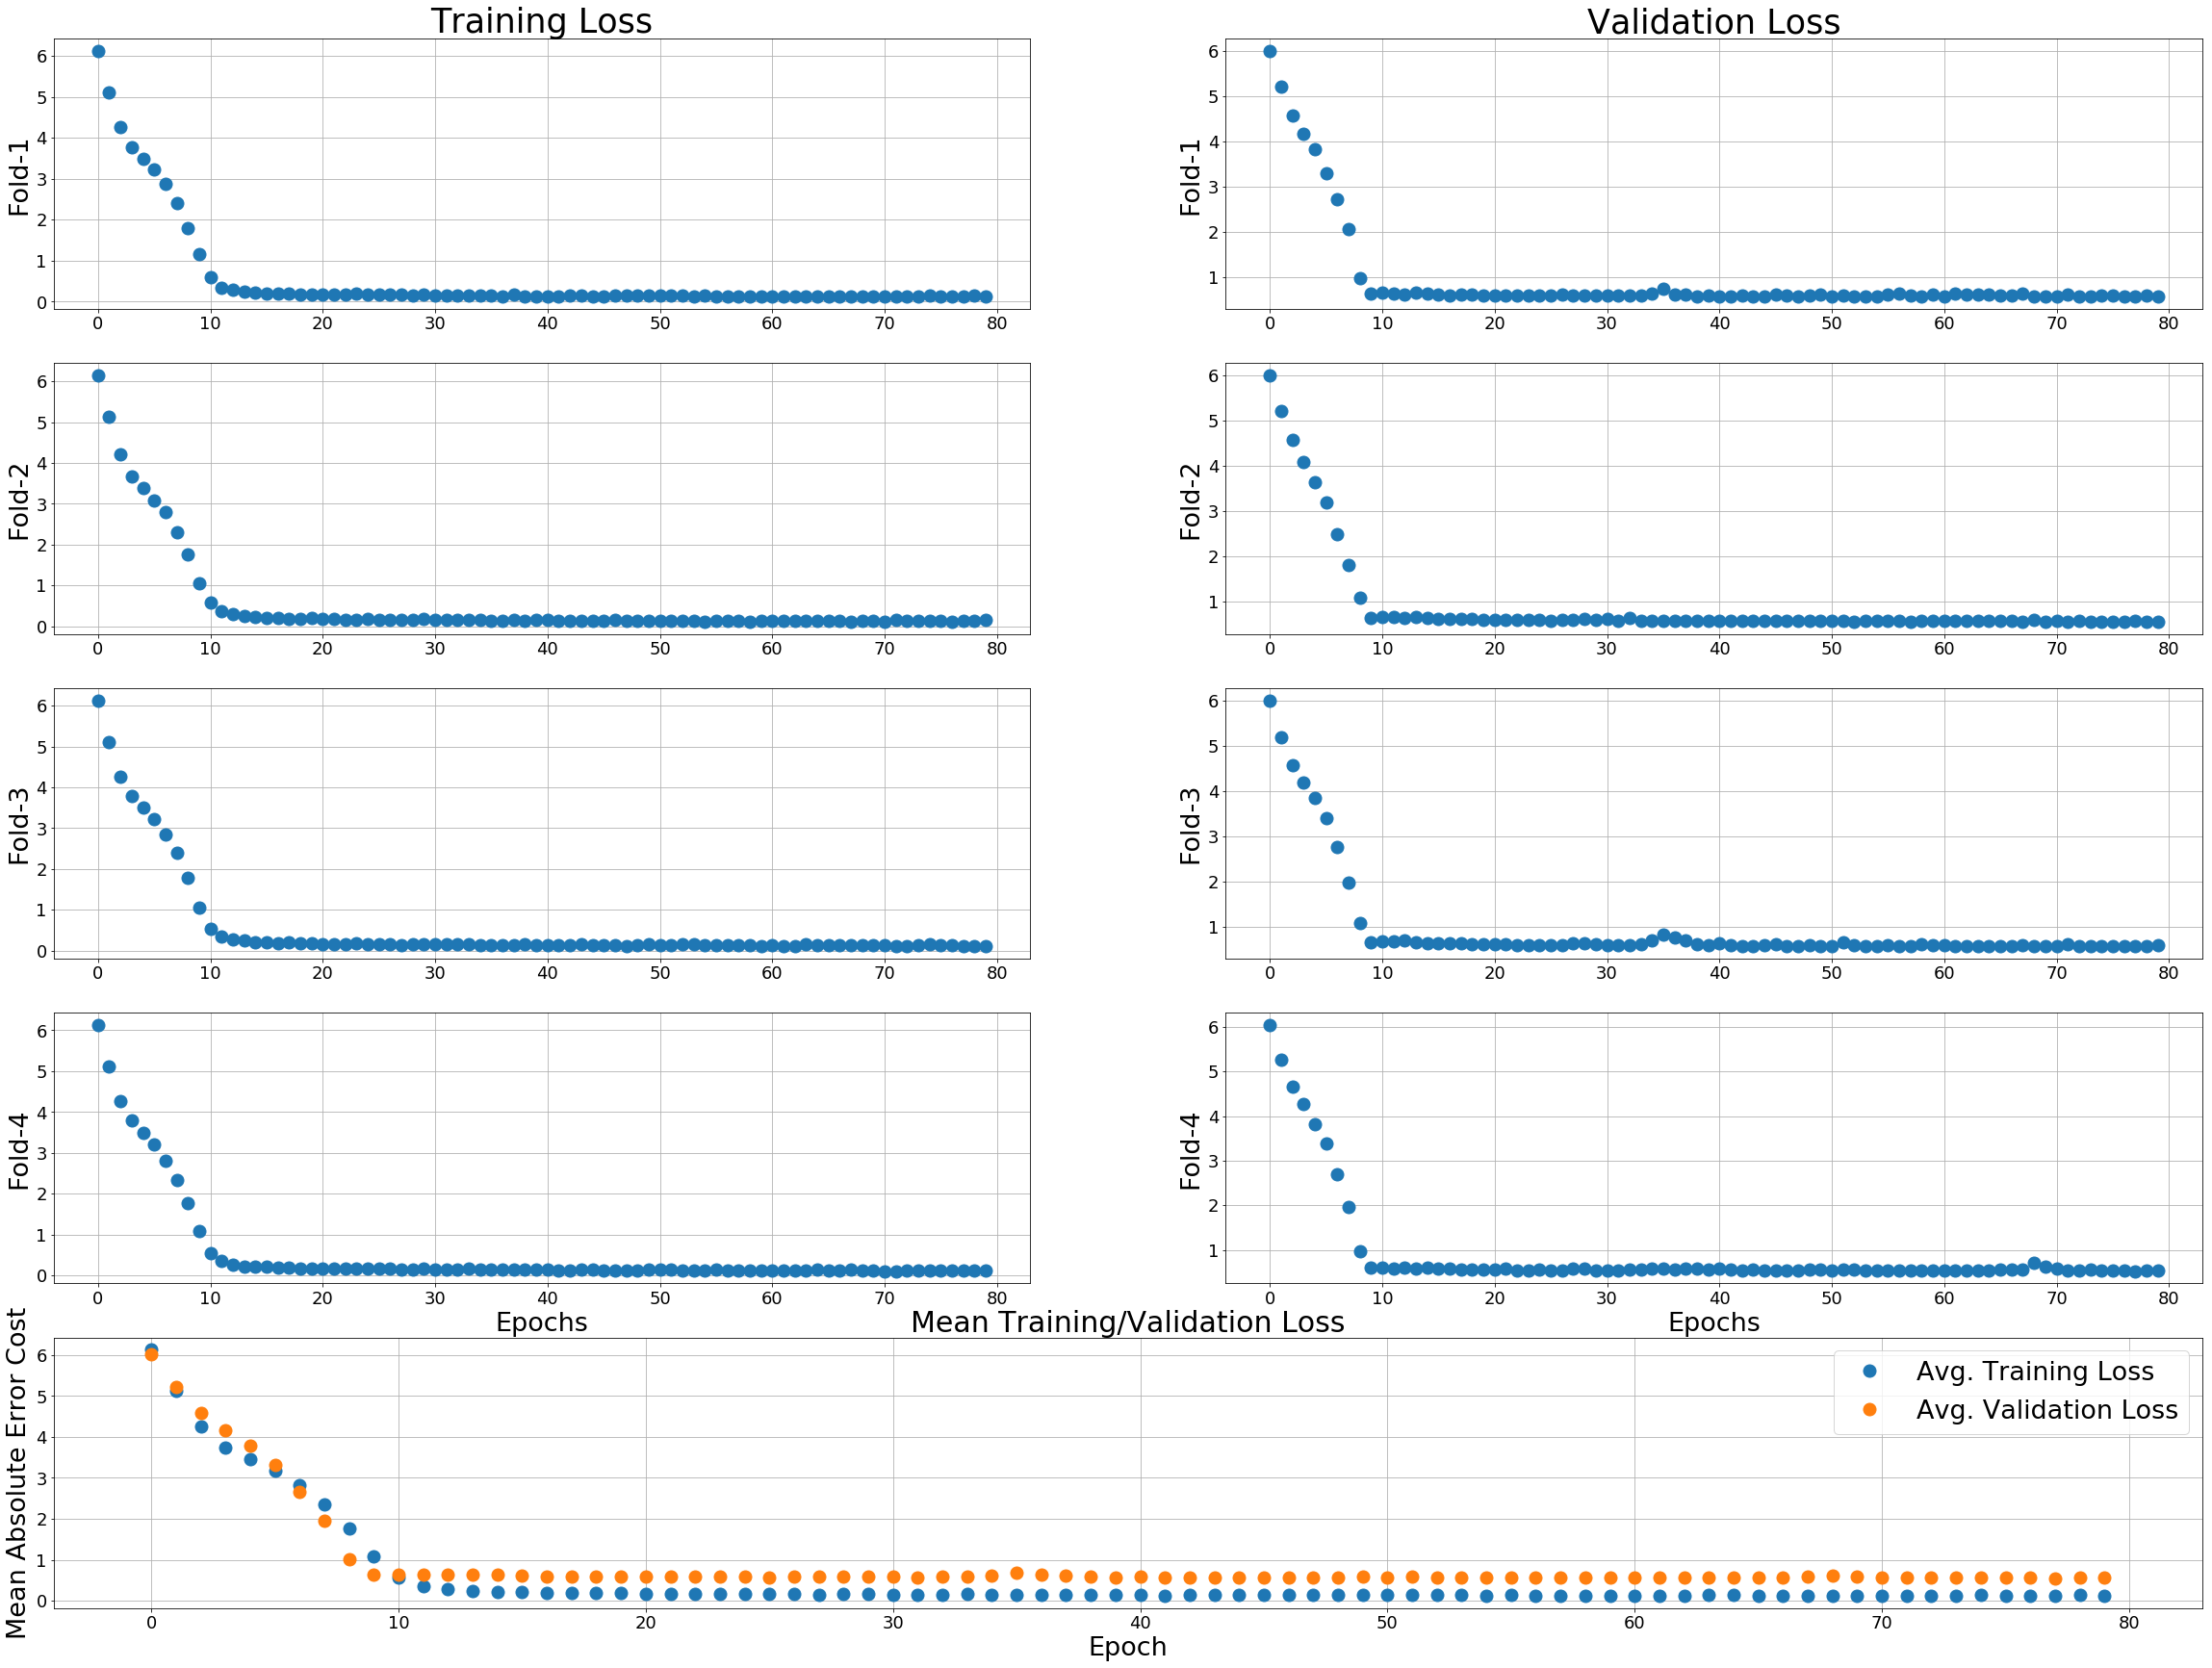

In [42]:
cvScoresHistory = np.asarray(cvScoresHistory)
meanTrainingLossHistory, meanValidationLossHistory = plotCrossValScores(cvScoresHistory, folds, num_epochs)

In [43]:
ind = np.lexsort( (meanTrainingLossHistory, meanValidationLossHistory) )
print('"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss\n')
print(ind)

print("\nTherefore, Epoch:" + str(ind[0]) + " would be a good place to stop training this model.")

"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss

[77 72 76 79 78 73 53 74 57 54 47 75 50 66 60 46 65 44 42 63 59 62 70 52 55
 58 43 64 31 71 25 56 45 41 61 39 48 23 69 49 24 29 33 22 20 30 26 38 67 19
 40 21 32 51 27 18 17 28 16 68 15 37 34 14 36 13  9 12 11 10 35  8  7  6  5
  4  3  2  1  0]

Therefore, Epoch:77 would be a good place to stop training this model.
